In [1]:
import numpy as np
import dolfin as dl
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from make_fenics_amg_solver import make_fenics_amg_solver
from random_fenics_function_makers import randn_fenics_function
from localpsf_helpers import *
from localpsf import *

from nalger_helper_functions import *
from product_convolution_operator import build_product_convolution_hmatrix_from_fenics_functions, build_product_convolution_operator_from_fenics_functions
import hlibpro_python_wrapper as hpro

In [2]:
# import numpy as np
# import dolfin as dl
# import scipy.sparse as sps
# import scipy.sparse.linalg as spla
# import scipy.io as sio
# # from fenics_to_scipy_sparse_csr_conversion import convert_fenics_csr_matrix_to_scipy_csr_matrix, vec2fct
# from fenics_interactive_impulse_response_plot import fenics_interactive_impulse_response_plot
# import matplotlib.pyplot as plt
# from fenics_function_smoother import FenicsFunctionSmoother
# from fenics_function_fast_grid_evaluator import FenicsFunctionFastGridEvaluator
# from mesh_makers import circle_mesh
# from random_fenics_function_makers import random_smooth_partition_of_unity, FenicsSmoothFunctionMaker, randn_fenics_function
# from plot_ellipse import plot_ellipse
# from interpolate_matrices import interpolate_matrices
# from make_fenics_amg_solver import make_fenics_amg_solver
# from poisson_interpolation import PoissonSquaredInterpolation
# from localpsf_helpers import *
# from localpsf import *
# import hlibpro_wrapper as hpro
# from basic_randomized_svd import basic_randomized_svd
# # from load_angel_peak_badlands_image_into_fenics import load_angel_peak_badlands_image_into_fenics
# from load_image_into_fenics import load_image_into_fenics
# from rbf_interpolation import PSFInterpolator
# from tqdm.auto import tqdm
# from nalger_helper_functions import *
# from scipy.spatial import cKDTree
# from localpsf_grid import LocalPSFGrid
# # from product_convolution_operator import build_product_convolution_operator_from_fenics_functions, square_root_of_product_convolution_operator

In [3]:
fine_mesh_h=5e-3
mesh_h= 3e-2 # 5e-2 # 1e-2
# mesh_h = 1.1e-2
finite_element_order=1
# final_time_T=5e-4
# final_time_T = 2.5e-3 # 1e-2
final_time_T = 5e-3
num_timesteps=35
# noise_level=5e-3
noise_level = 1e-8
mesh_center = np.array([0.5,0.5])
mesh_radius = 0.5
num_random_matrices_for_conductivity_field= 4
conductivity_interpolation_temperature= 5 #3
boundary_tol = 0.5
num_std_dev_tau=3
# a_reg = 1e-4 # Morozov: 4.4 % noise
a_reg = 5e-5 # Morozov: 2.9 % noise <-- good
# a_reg = 2e-5 # Morozov: 1.7 % noise
# a_reg = 1e-5 # Morozov: 1.2 % noise
# a_reg = 1e-6 # Morozov: 0.58 % noise, too small for mesh?

np.random.seed(1)

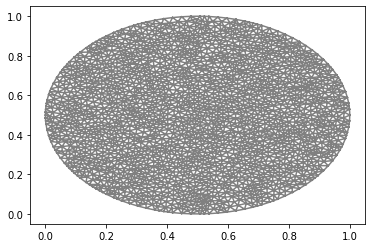

In [4]:
mesh = circle_mesh(mesh_center, mesh_radius, mesh_h)
# mesh_n = int(1./mesh_h)
# mesh = dl.UnitSquareMesh(mesh_n, mesh_n)
V = dl.FunctionSpace(mesh, 'CG', finite_element_order)
dl.plot(mesh)

X = V.tabulate_dof_coordinates()
N = V.dim()
d = mesh.geometric_dimension()

Make conductivity field $\kappa$ defined by
$$\kappa_{ij}(x) := \sum_{k=1}^4 w_k(x)\left(C_k\right)_{ij}$$
where $C_k$ are randomish matrices and $w_k$ are randomish smooth fields.

We build the functions $w_k$ on a very fine grid that always stays the same for reproducibility, then interpolate them to different coarser grid for different runs/numerical experiments.

Text(0.5, 1.0, 'f_23')

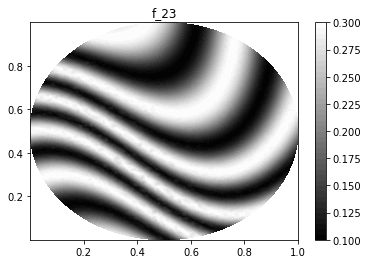

In [5]:
def wiggly_function(V0):
    n=150
    mesh = dl.RectangleMesh(dl.Point(-1.,-1.), dl.Point(2., 2.), n,n)
    V = dl.FunctionSpace(mesh, 'CG', 2)
    u = dl.interpolate(dl.Expression('0.2 + 0.1*sin(30*x[0])',domain=mesh, degree=5), V)
    old_coords = mesh.coordinates()

    xx0 = old_coords[:,0]
    yy0 = old_coords[:,1]

    xx1 = xx0
    yy1 = yy0 + 0.2 * np.cos(3.5*xx0)

    xx2 = yy1 + 0.3 * xx1
    yy2 = xx1 + 0.3 * np.sin(3.5*(yy1-0.35))

    xx3 = (xx2 + yy2)
    yy3 = (xx2 - yy2) + 0.2 * np.cos(4*(xx2 + yy2))

    new_coords = np.array([xx3, yy3]).T

    mesh.coordinates()[:] = new_coords

    u0 = dl.interpolate(u, V0)
    return u0

kappa = wiggly_function(V)

cm = dl.plot(kappa, cmap='gray')
plt.colorbar(cm)
plt.title(kappa)

Text(0.5, 1.0, 'zeta')

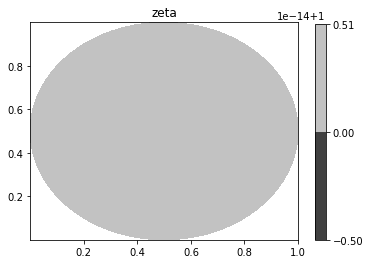

In [6]:
# zeta_expr = dl.Expression('200.0 * sin(2*pi*x[0]*x[1]-x[1]*x[1]-2.1)', degree=5, domain=mesh)
# zeta = dl.interpolate(zeta_expr, V)
zeta = load_image_into_fenics(V, 'aces_building.png')
# zeta.vector()[:] = 300. * (zeta.vector()[:] - 0.5)
zeta.vector()[:] = 1.

cm = dl.plot(zeta, cmap='gray')
plt.colorbar(cm)
plt.title('zeta')

In [7]:
u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

mass_form = u_trial * v_test * dl.dx
M = dl.assemble(mass_form)
solve_M = make_fenics_amg_solver(M)

# stiffness_form = fenics.inner(kappa * fenics.grad(u_trial), fenics.grad(v_test)) * fenics.dx
stiffness_form = dl.inner(kappa * dl.grad(u_trial), dl.grad(v_test)) * dl.dx \
                 + zeta * u_trial * v_test * dl.dx
A = dl.assemble(stiffness_form)

In [8]:
delta_t = final_time_T / num_timesteps
Z_minus = M
Z_plus = M + delta_t * A

solve_Z_plus = make_fenics_amg_solver(Z_plus)

Text(0.5, 1.0, 'u0_true')

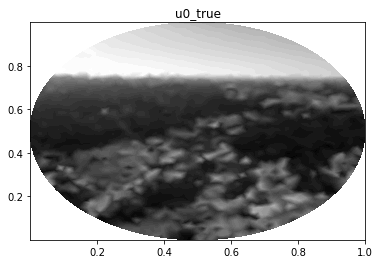

In [9]:
# zz = random_smooth_partition_of_unity(100, V, temperature=10, normalize=True)
# # zz = random_smooth_partition_of_unity(25, V, temperature=10, normalize=True)
#
# u0_true = fenics.Function(V)
# for k in range(len(zz)):
#     u0_true.vector()[:] = u0_true.vector() + (k**2) * zz[k].vector()

# u0_true = load_angel_peak_badlands_image_into_fenics(V)
u0_true = load_image_into_fenics(V, 'angel_peak_badlands.png')
# u0_true = load_image_into_fenics(V, 'aces_building.png')
plt.figure()

dl.plot(u0_true, cmap='gray')
plt.title('u0_true')

In [10]:
def forward_map(u0_petsc):
    uT_petsc = dl.Vector(u0_petsc)
    for k in range(num_timesteps):
        uT_petsc = solve_Z_plus(Z_minus * uT_petsc)
    return uT_petsc

Text(0.5, 1.0, 'uT_true')

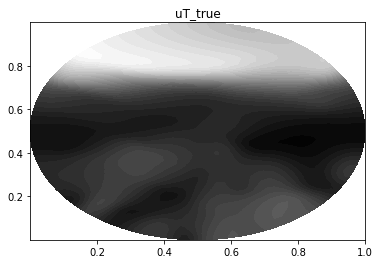

In [11]:
uT_true = dl.Function(V)
uT_true.vector()[:] = forward_map(u0_true.vector())
dl.plot(uT_true, cmap='gray')
plt.title('uT_true')

In [12]:
def adjoint_map(vT_petsc):
    v0_petsc = dl.Vector(vT_petsc)
    for k in range(num_timesteps):
        v0_petsc = Z_minus * solve_Z_plus(v0_petsc)
    return v0_petsc

Perform adjoint correctness check

In [13]:
x = randn_fenics_function(V)
y = randn_fenics_function(V)
adjoint_err = np.abs(forward_map(x.vector()).inner(y.vector())
                     - x.vector().inner(adjoint_map(y.vector())))
print('adjoint_err=', adjoint_err)

adjoint_err= 3.5106091367254066e-09


true_noise_level= 9.890890098971443e-09


Text(0.5, 1.0, 'uT_obs')

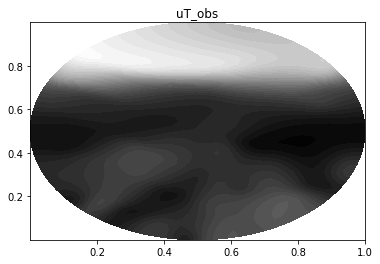

In [14]:
N = V.dim() 
normalized_noise = np.random.randn(N) / np.sqrt(N)
uT_obs = dl.Function(V)
uT_obs.vector()[:] = uT_true.vector()[:] + noise_level * normalized_noise * np.linalg.norm(uT_true.vector()[:])

true_noise_level = dl.norm(uT_obs.vector() - uT_true.vector())/dl.norm(uT_true.vector())
print('true_noise_level=', true_noise_level)
dl.plot(uT_obs, cmap='gray')
plt.title('uT_obs')

In [15]:
def objective(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    J = 0.5 * discrepancy.inner(M * discrepancy)
    return J

In [16]:
objective(u0_true.vector())

3.8597556436797975e-18

In [17]:
def gradient(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    return adjoint_map(M * discrepancy)

In [18]:
def apply_hessian(p_petsc):
    return adjoint_map(M * forward_map(p_petsc))

apply_Hd = apply_hessian
apply_Hd_t = apply_hessian

## Finite difference check for gradient and Hessian

In [19]:
u0 = dl.Function(V)
u0.vector()[:] = np.random.randn(V.dim())

J = objective(u0.vector())
g = gradient(u0.vector())

du = dl.Function(V)
du.vector()[:] = np.random.randn(V.dim())

In [20]:
ss = np.logspace(-15, 0, 11)
grad_errs = np.zeros(len(ss))
for k in range(len(ss)):
    s = ss[k]
    u0_2_vector = u0.vector() + s * du.vector()

    J2 = objective(u0_2_vector)
    dJ_diff = (J2 - J) / s
    dJ = g.inner(du.vector())
    grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)
    grad_errs[k] = grad_err

    print('s=', s, ', grad_err=', grad_err)

<ipython-input-20-a19fad4e0606>:10: RuntimeWarning: divide by zero encountered in double_scalars
  grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)


s= 1e-15 , grad_err= inf
s= 3.1622776601683796e-14 , grad_err= 0.022915753978473306
s= 1e-12 , grad_err= 0.000979301364299267
s= 3.1622776601683794e-11 , grad_err= 7.200399253830084e-05
s= 1e-09 , grad_err= 1.1535307731670251e-06
s= 3.162277660168379e-08 , grad_err= 1.7111001946014251e-07
s= 1e-06 , grad_err= 7.761748258114087e-07
s= 3.1622776601683795e-05 , grad_err= 2.4463259739573582e-05
s= 0.001 , grad_err= 0.0007741847573966267
s= 0.03162277660168379 , grad_err= 0.025076390025203912
s= 1.0 , grad_err= 3.416694688495196


hess_err= 7.576025244614947e-10


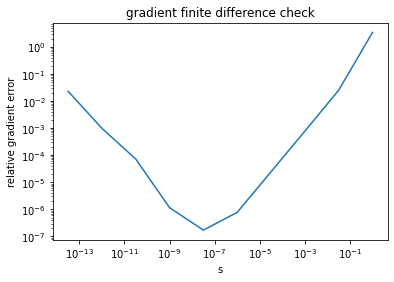

In [21]:
plt.figure()
plt.loglog(ss, grad_errs)
plt.title('gradient finite difference check')
plt.xlabel('s')
plt.ylabel('relative gradient error')

u0_2 = dl.Function(V)
u0_2.vector()[:] = np.random.randn(V.dim())
dg = apply_hessian(u0_2.vector() - u0.vector())
g2 = gradient(u0_2.vector())
dg_diff = g2 - g
hess_err = dl.norm(dg - dg_diff) / dl.norm(dg_diff)
print('hess_err=', hess_err)

## Visualize Hessian impulse responses

$$g \mapsto M^{-1} H M^{-1} g$$

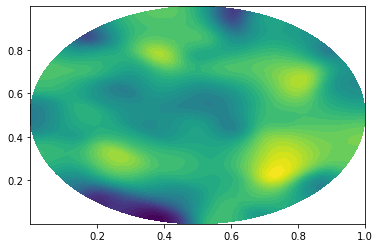

In [22]:
g = dl.Function(V)
g.vector()[:] = np.random.randn(V.dim())

Hg = dl.Function(V)
Hg.vector()[:] = solve_M(apply_Hd(solve_M(g.vector())))

dl.plot(Hg)

Text(0.5, 1.0, 'point source at [0.2 0.5]')

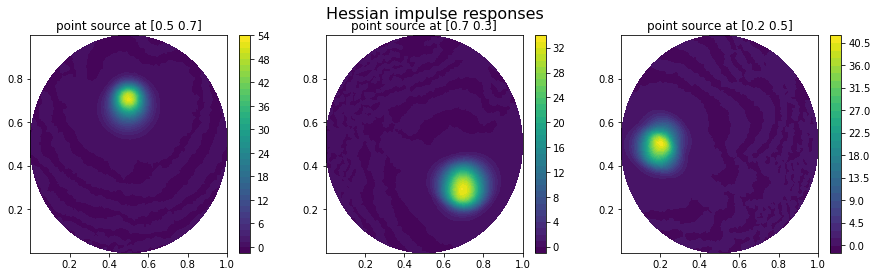

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.suptitle('Hessian impulse responses', fontsize=16)

plt.sca(axes[0])
pp = np.array([[0.5,0.7]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = dl.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[1])
pp = np.array([[0.7,0.3]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = dl.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[2])
pp = np.array([[0.2,0.5]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = dl.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

making mass matrix and solver
getting spatially varying volume
getting spatially varying mean
getting spatially varying covariance
constructing fast evaluators
done
getting nodes on boundary
done
computing inds of points far from boundary
done


/home/nick/repos/localpsf/code/localpsf_helpers.py:65: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  if ellipsoids_intersect(Sigma_perm[x_ind, :, :], Sigma_perm[p_ind, :, :], mu_perm[x_ind, :],


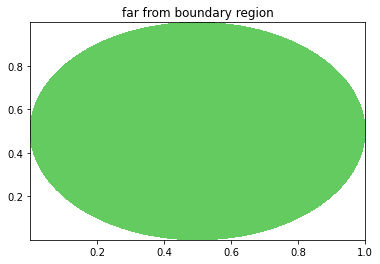

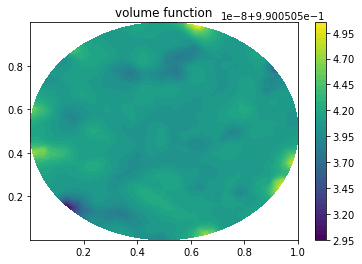

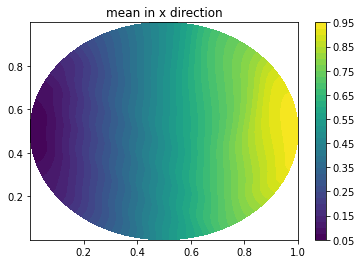

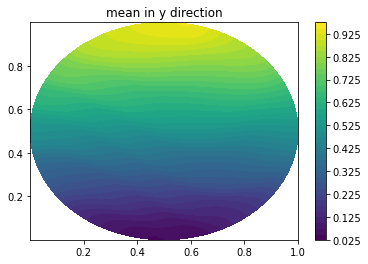

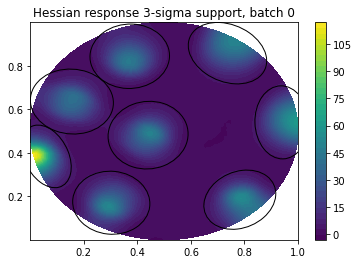

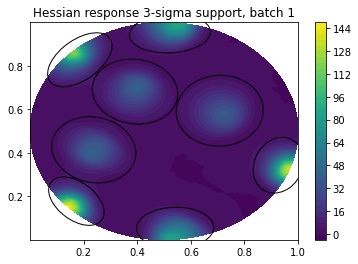

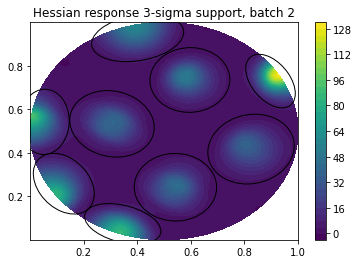

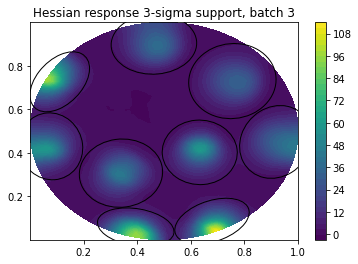

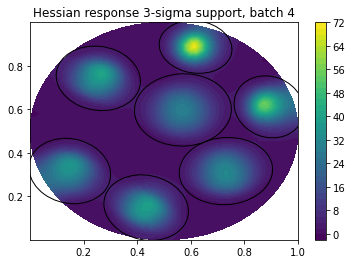

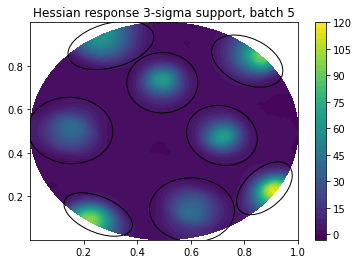

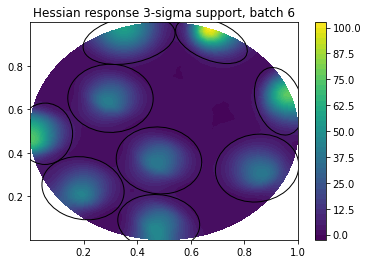

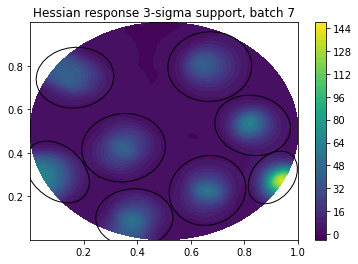

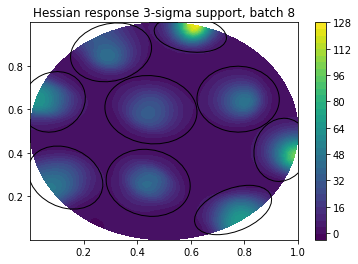

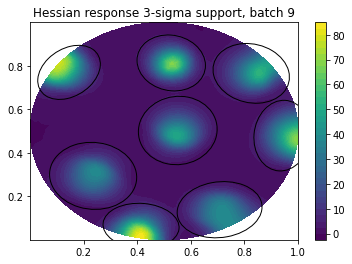

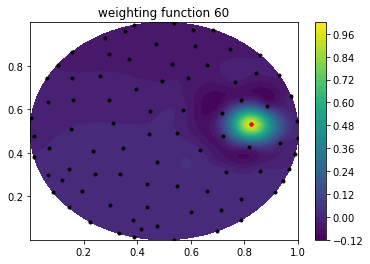

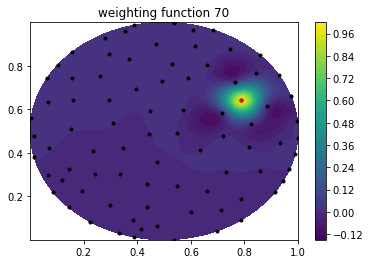

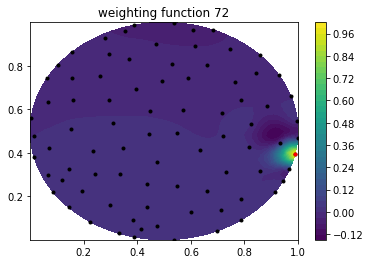

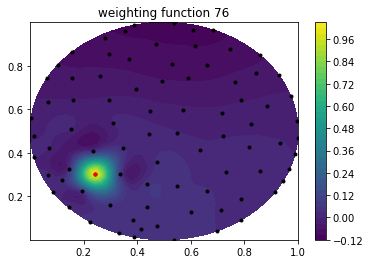

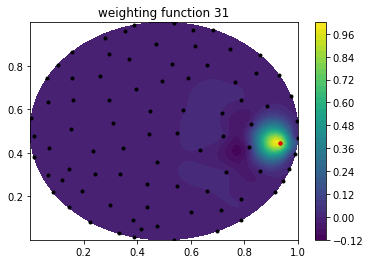

In [24]:
lpsf = LocalPSF(apply_Hd, apply_Hd_t, V, max_batches=10, num_standard_deviations_tau=2.5)
# lpsf = LocalPSF(apply_Hd, apply_Hd_t, V, max_batches=5, num_standard_deviations_tau=2.5)

lpsf.make_plots()

Forming weighting function patches and (un-extended) convolution kernel patches


  0%|          | 0/83 [00:00<?, ?it/s]

Filling in missing kernel entries using neighboring kernels


  0%|          | 0/83 [00:00<?, ?it/s]

Building cluster trees and block cluster tree
Building product convolution hmatrix from patches


/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:212: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.array)


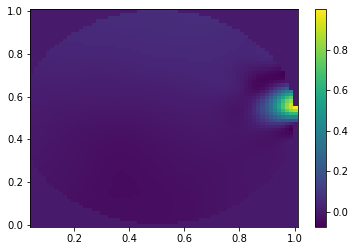

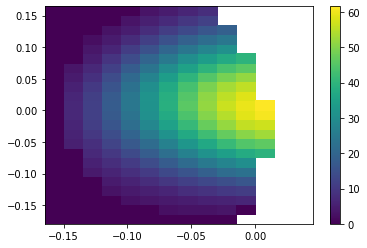

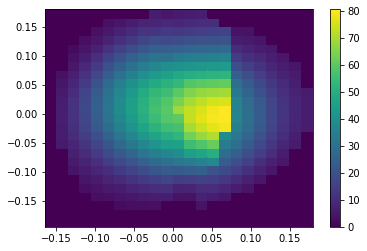

In [25]:
ww = lpsf.weighting_functions
ff_batches = lpsf.dirac_comb_responses
pp = np.vstack(lpsf.point_batches)
all_mu = np.vstack(lpsf.mu_batches)
all_Sigma = np.vstack(lpsf.Sigma_batches)
tau = lpsf.tau
batch_lengths = [ppk.shape[0] for ppk in lpsf.point_batches]

Hd_hmatrix, WW, FF, initial_FF = \
    build_product_convolution_hmatrix_from_fenics_functions(ww, ff_batches, batch_lengths, pp,
                                                            all_mu, all_Sigma, tau, 
                                                            w_support_rtol=2e-2, return_extras=True)

k=0

WW[k].plot()
initial_FF[k].plot()
FF[k].plot()

dt_hessian= 0.09413528442382812
dt_hmatrix= 0.003831624984741211
err_matvec= 0.19247857823693812


Text(0.5, 1.0, 'err')

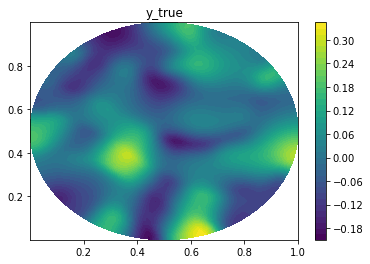

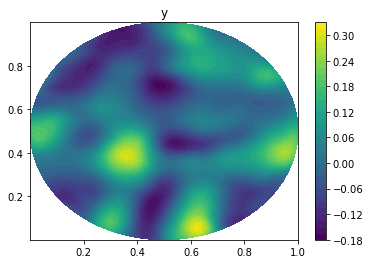

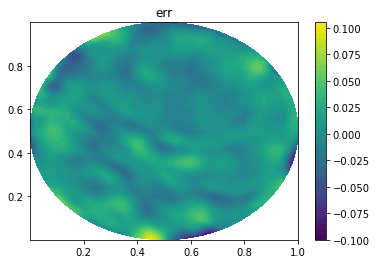

In [33]:
z = dl.Function(V)
z.vector()[:] = np.random.randn(V.dim())
# z.vector()[:] = kappa.vector()[:].copy()

y_true = dl.Function(V)
t = time()
y_true.vector()[:] = solve_M(apply_Hd(z.vector()))
dt_hessian = time() - t
print('dt_hessian=', dt_hessian)

y = dl.Function(V)
t = time()
y.vector()[:] = Hd_hmatrix * (M * z.vector()[:]) # Good
# y.vector()[:] = PC.matvec(z.vector()[:])
dt_hmatrix = time() - t
print('dt_hmatrix=', dt_hmatrix)

plt.figure()
cm = dl.plot(y_true)
plt.colorbar(cm)
plt.title('y_true')

plt.figure()
cm = dl.plot(y)
plt.colorbar(cm)
plt.title('y')

err_matvec = np.linalg.norm(y.vector()[:] - y_true.vector()[:])/np.linalg.norm(y_true.vector()[:])

print('err_matvec=', err_matvec)

ee = dl.Function(V)
ee.vector()[:] = y.vector()[:] - y_true.vector()[:]

plt.figure()
cm = dl.plot(ee)
plt.colorbar(cm)
plt.title('err')

  0%|          | 0/30 [00:00<?, ?it/s]

norm_Hd= 4.5035701099525145 , norm_Hd_err= 1.1761801932089904
relative_Hd_err= 0.26116617805276976


Text(0.5, 1.0, 'Hd_relative_err_fct')

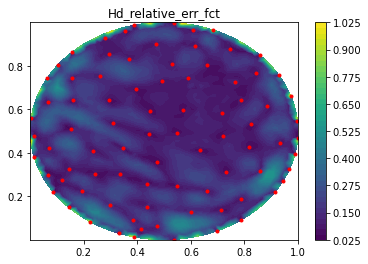

In [27]:
apply_Hd_t = apply_Hd
Hd_hmatrix_T = Hd_hmatrix.T

def apply_M_numpy(x_numpy):
    x = dl.Function(V)
    x.vector()[:] = x_numpy.copy()
    return (M * x.vector())[:]
    

def solve_M_numpy(x_numpy):
    x = dl.Function(V)
    x.vector()[:] = x_numpy.copy()
    return solve_M(x.vector())[:]

def apply_Hd_t_numpy(x_numpy):
    x = dl.Function(V)
    x.vector()[:] = x_numpy.copy()
    return solve_M_numpy(apply_Hd_t(x.vector())[:])

n_random = 30
Omega = np.random.randn(V.dim(), n_random)
Y_true = np.zeros((V.dim(), n_random))
Y = np.zeros((V.dim(), n_random))
for k in tqdm(range(n_random)):
    Y_true[:,k] = apply_Hd_t_numpy(Omega[:,k])
    Y[:,k] = Hd_hmatrix_T.matvec(apply_M_numpy(Omega[:,k])) #
    # Y_true[lpsf.inds_of_points_far_from_boundary,k] = apply_Hd_t_numpy(Omega[:,k])[lpsf.inds_of_points_far_from_boundary]
    # Y[lpsf.inds_of_points_far_from_boundary,k] = Hd_hmatrix_T.matvec(Omega[:,k])[lpsf.inds_of_points_far_from_boundary] #

norm_Hd = np.linalg.norm(Y_true) / np.sqrt(n_random)
norm_Hd_err = np.linalg.norm(Y_true - Y) / np.sqrt(n_random)

relative_Hd_err = norm_Hd_err / norm_Hd
print('norm_Hd=', norm_Hd, ', norm_Hd_err=', norm_Hd_err)
print('relative_Hd_err=', relative_Hd_err)

Hd_norm_vec = np.linalg.norm(Y_true, axis=1) / np.sqrt(n_random)
Hd_err_vec = np.linalg.norm(Y_true - Y, axis=1) / np.sqrt(n_random)
Hd_relative_err_vec = Hd_err_vec / Hd_norm_vec
Hd_relative_err_fct = dl.Function(V)
Hd_relative_err_fct.vector()[:] = Hd_relative_err_vec

cm = dl.plot(Hd_relative_err_fct)
plt.colorbar(cm)

plt.plot(lpsf.points[:, 0], lpsf.points[:, 1], '.r')

plt.title('Hd_relative_err_fct')

In [37]:
V.dim() / 16

138.375

In [28]:
Hd_hmatrix.visualize('Hd_hmatrix')

In [34]:
Hd_plus = hpro.hmatrix_symmetric_positive_definite_rational_approximation(Hd_hmatrix, rtol=5e-2)

A.sym(): lambda_min= -63.726624298799834 , lambda_max= 2857.8871675846663
━━ H-matrix inverse ( rtol =  0.05 , atol =  1e-15 , overwrite= True  )
    done in  13.302292823791504
    size of inverse =  11305569  bytes


In [35]:
Hd_plus.visualize('Hd_plus')

dt_hessian= 0.09079670906066895
dt_hmatrix= 0.003202676773071289
err_matvec= 0.19680107347875248


Text(0.5, 1.0, 'err')

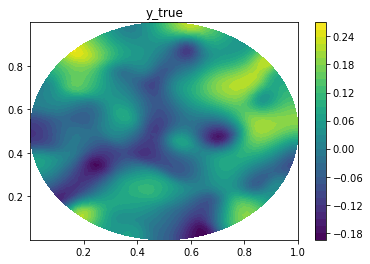

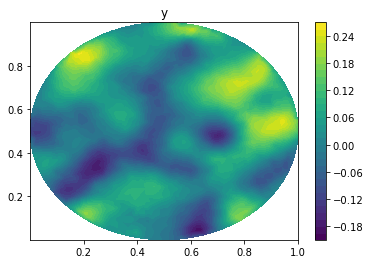

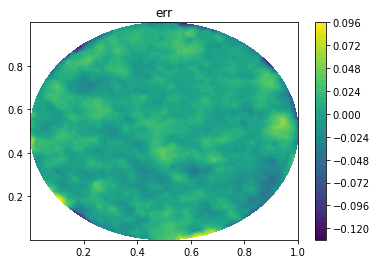

In [38]:
z = dl.Function(V)
z.vector()[:] = np.random.randn(V.dim())
# z.vector()[:] = kappa.vector()[:].copy()

y_true = dl.Function(V)
t = time()
y_true.vector()[:] = solve_M(apply_Hd(z.vector()))
dt_hessian = time() - t
print('dt_hessian=', dt_hessian)

y = dl.Function(V)
t = time()
y.vector()[:] = Hd_plus * (M * z.vector()[:])
# y.vector()[:] = Hd_hmatrix * (M * z.vector()[:]) # Good
dt_hmatrix = time() - t
print('dt_hmatrix=', dt_hmatrix)

plt.figure()
cm = dl.plot(y_true)
plt.colorbar(cm)
plt.title('y_true')

plt.figure()
cm = dl.plot(y)
plt.colorbar(cm)
plt.title('y')

err_matvec = np.linalg.norm(y.vector()[:] - y_true.vector()[:])/np.linalg.norm(y_true.vector()[:])

print('err_matvec=', err_matvec)

ee = dl.Function(V)
ee.vector()[:] = y.vector()[:] - y_true.vector()[:]

plt.figure()
cm = dl.plot(ee)
plt.colorbar(cm)
plt.title('err')

  0%|          | 0/30 [00:00<?, ?it/s]

norm_Hd= 4.6514382467065225 , norm_Hd_err= 0.9544220914610485
relative_Hd_err= 0.20518859777120174


Text(0.5, 1.0, 'Hd_relative_err_fct')

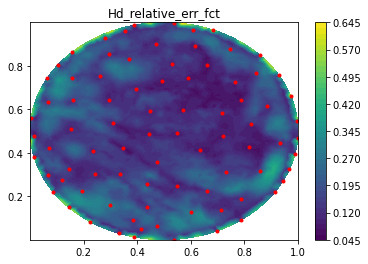

In [40]:
Hd_plus_T = Hd_plus.T

n_random = 30
Omega = np.random.randn(V.dim(), n_random)
Y_true = np.zeros((V.dim(), n_random))
Y = np.zeros((V.dim(), n_random))
for k in tqdm(range(n_random)):
    Y_true[:,k] = apply_Hd_t_numpy(Omega[:,k])
    Y[:,k] = Hd_plus_T.matvec(apply_M_numpy(Omega[:,k])) #
    # Y_true[lpsf.inds_of_points_far_from_boundary,k] = apply_Hd_t_numpy(Omega[:,k])[lpsf.inds_of_points_far_from_boundary]
    # Y[lpsf.inds_of_points_far_from_boundary,k] = Hd_hmatrix_T.matvec(Omega[:,k])[lpsf.inds_of_points_far_from_boundary] #

norm_Hd = np.linalg.norm(Y_true) / np.sqrt(n_random)
norm_Hd_err = np.linalg.norm(Y_true - Y) / np.sqrt(n_random)

relative_Hd_err = norm_Hd_err / norm_Hd
print('norm_Hd=', norm_Hd, ', norm_Hd_err=', norm_Hd_err)
print('relative_Hd_err=', relative_Hd_err)

Hd_norm_vec = np.linalg.norm(Y_true, axis=1) / np.sqrt(n_random)
Hd_err_vec = np.linalg.norm(Y_true - Y, axis=1) / np.sqrt(n_random)
Hd_relative_err_vec = Hd_err_vec / Hd_norm_vec
Hd_relative_err_fct = dl.Function(V)
Hd_relative_err_fct.vector()[:] = Hd_relative_err_vec

cm = dl.plot(Hd_relative_err_fct)
plt.colorbar(cm)

plt.plot(lpsf.points[:, 0], lpsf.points[:, 1], '.r')

plt.title('Hd_relative_err_fct')

In [47]:
PC = build_product_convolution_operator_from_fenics_functions(ww, ff_batches, pp, 
                                                              all_mu, all_Sigma, tau, batch_lengths,
                                                              grid_density_multiplier=1.0, w_support_rtol=2e-2,
                                                              num_extension_kernels=8, V_out=None)

Forming weighting function patches and (un-extended) convolution kernel patches


  0%|          | 0/83 [00:00<?, ?it/s]

Filling in missing kernel entries using neighboring kernels


  0%|          | 0/83 [00:00<?, ?it/s]

constructing dofs2patch transfer matrices


  0%|          | 0/83 [00:00<?, ?it/s]

constructing patch2dofs transfer matrices


  0%|          | 0/83 [00:00<?, ?it/s]

precomputing which patches are relevant for each row


  0%|          | 0/83 [00:00<?, ?it/s]

precomputing which patches are relevant for each column


  0%|          | 0/83 [00:00<?, ?it/s]

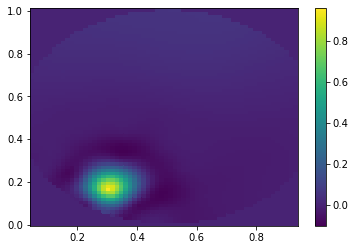

In [53]:
PC.WW[1].plot()

In [28]:
u = np.random.randn(V.dim())
v = np.random.randn(V.dim())

t = time()
T_u = PC.matvec(u)
dt_matvec = time() - t
print('dt_matvec=', dt_matvec)

t = time()
Tstar_v = PC.rmatvec(v)
dt_rmatvec = time() - t
print('dt_rmatvec=', dt_rmatvec)

err_PC_adjoint = np.dot(T_u, v) - np.dot(u, Tstar_v)
print('err_PC_adjoint=', err_PC_adjoint)

dt_matvec= 0.041948795318603516
dt_rmatvec= 0.10341167449951172
err_PC_adjoint= -3.1086244689504383e-15


In [30]:
num_entries = 1000
rows = np.random.randint(0, PC.shape[0], num_entries)
cols = np.random.randint(0, PC.shape[1], num_entries)

t = time()
e1 = PC.get_scattered_entries(rows, cols)
dt_get_entries = time() - t
print('dt_get_entries=', dt_get_entries)

t = time()
e2 = PC.get_scattered_entries_slow(rows, cols)
dt_get_entries_slow = time() - t
print('dt_get_entries_slow=', dt_get_entries_slow)

err_get_entries = np.linalg.norm(e2-e1)
print('err_get_entries=', err_get_entries)

computing 1000 matrix entries in batches of 1000


  0%|          | 0/1 [00:00<?, ?it/s]

dt_get_entries= 0.12706637382507324
computing 1000 entries


  0%|          | 0/1000 [00:00<?, ?it/s]

dt_get_entries_slow= 20.977554321289062
err_get_entries= 0.0


In [31]:
num_entries = 1000000
rows = np.random.randint(0, PC.shape[0], num_entries)
cols = np.random.randint(0, PC.shape[1], num_entries)

t = time()
e1 = PC.get_scattered_entries(rows, cols)
dt_get_entries = time() - t
print('dt_get_entries=', dt_get_entries)

entries_per_second = num_entries / dt_get_entries
print('entries_per_second=', entries_per_second)

computing 1000000 matrix entries in batches of 1000000


  0%|          | 0/1 [00:00<?, ?it/s]

dt_get_entries= 34.22107672691345
entries_per_second= 29221.75733919972


In [32]:
block_rows = np.random.randint(0, PC.shape[0], 350)
block_cols = np.random.randint(0, PC.shape[1], 363)
# block_rows = np.arange(63, 1055)
# block_cols = np.arange(921, 1835)

t = time()
PCB = PC.get_block(block_rows, block_cols)
dt_get_block = time() - t
print('dt_get_block=', dt_get_block)

num_block_entries = len(block_rows) * len(block_cols)
entries_per_second_block = num_block_entries / dt_get_block
print('entries_per_second_block=', entries_per_second_block)

rows = list()
cols = list()
for ii in range(len(block_rows)):
    for jj in range(len(block_cols)):
        rows.append(block_rows[ii])
        cols.append(block_cols[jj])
rows = np.array(rows)
cols = np.array(cols)

t = time()
QQQ = PC.get_scattered_entries(rows, cols).reshape((len(block_rows), len(block_cols)))
dt_get_entries = time() - t
print('dt_get_entries=', dt_get_entries)

entries_per_second_scattered = num_entries / dt_get_entries
print('entries_per_second_scattered=', entries_per_second_scattered)

computing 350 x 363 matrix block in batches of 2755 cols


  0%|          | 0/1 [00:00<?, ?it/s]

dt_get_block= 4.435460329055786
entries_per_second_block= 28644.15203259099
computing 127050 matrix entries in batches of 127050


  0%|          | 0/1 [00:00<?, ?it/s]

dt_get_entries= 3.5327560901641846
entries_per_second_scattered= 283065.1124724337


In [33]:
np.linalg.norm(QQQ - PCB)

0.0

In [34]:
rows = list()
cols = list()
for ii in range(len(block_rows)):
    for jj in range(len(block_cols)):
        rows.append(block_rows[ii])
        cols.append(block_cols[jj])
rows = np.array(rows)
cols = np.array(cols)

PCB2 = PC.get_scattered_entries(rows, cols).reshape((len(block_rows), len(block_cols)))

np.linalg.norm(PCB - PCB2)

computing 127050 matrix entries in batches of 127050


  0%|          | 0/1 [00:00<?, ?it/s]

0.0

In [35]:
z0_vec = kappa.vector().copy()
# z0_vec[:] = np.random.randn(V.dim())
z0_dual_vec = M * z0_vec

z_dual_vec = z0_dual_vec.copy()
z_dual_vec.zero()
z_dual_vec[block_cols] = z0_dual_vec[block_cols]

z_vec = solve_M(z_dual_vec)
y1 = PC.matvec(z_vec[:])[block_rows]

y2 = np.dot(PCB, z_dual_vec[block_cols])
err_block_vs_conv = np.linalg.norm(y2 - y1) / np.linalg.norm(y1)
print('err_block_vs_conv=', err_block_vs_conv)

y3 = solve_M(apply_Hd(z_vec))[block_rows]
err_block_vs_true = np.linalg.norm(y2 - y3) / np.linalg.norm(y3)
print('err_block_vs_true=', err_block_vs_true)


err_conv_vs_true = np.linalg.norm(y1 - y3) / np.linalg.norm(y3)
print('err_conv_vs_true=', err_conv_vs_true)


err_block_vs_conv= 0.10509971084942529
err_block_vs_true= 0.12256043997899999
err_conv_vs_true= 0.1108452239209401


In [38]:
t = time()
PC_dense = PC.get_block(np.arange(V.dim()), np.arange(V.dim()))
dt_get_dense = time() - t
print('dt_get_dense=', dt_get_dense)

computing 8281 x 8281 matrix block


  0%|          | 0/69 [00:00<?, ?it/s]

dt_get_dense= 472.55624079704285


In [111]:
# z0 = np.random.randn(len(block_cols))
# z = np.zeros(V.dim())
# z[block_cols] = z0
# y = PC.matvec(z)[block_rows]
y = PC.matvec(z_fct.vector())[block_rows]

# z_fct = dl.Function(V)
# z_fct.vector()[block_cols] = z0

# y2 = np.dot(PCB * PC.WW[0].dV, (z_fct.vector())[block_cols])
y2 = np.dot(PCB, (M * z_fct.vector())[block_cols])

np.linalg.norm(y2 - y) / np.linalg.norm(y2)

0.9056120221543287

In [109]:
2*y2 / y

array([ 1.03372098,  1.07495903,  0.97950019,  1.13629097,  1.13191698,
        0.62051724,  0.97635482,  0.73998047,  1.09599091,  1.19282198,
        2.19859322,  1.26320022,  1.08179469,  1.09738493,  1.00308253,
        1.03073597,  1.27719172,  0.46768997,  0.99527571,  1.50415606,
        1.0069463 ,  0.98342672,  0.99330687,  1.04621236,  0.41696818,
        0.99979164,  1.07979922,  1.03264645,  1.35049033,  1.00127948,
        1.30591918, -0.22793437,  0.99185938,  1.        ,  0.55825524,
        2.03941841,  0.9489128 , -7.4087222 , -0.96235744,  1.14913057,
        1.46132985,  1.00624912,  0.98333041, -0.6551149 ,  0.9960946 ,
        1.77004029,  1.02814666,  1.0149747 ,  0.71381868,  1.16414897,
        1.50824859,  0.99993904,  0.80174119,  1.11956674,  1.14578256,
        0.87555688,  1.17714151,  0.99330573,  0.66273495,  0.98709048,
        1.08696898,  0.97235235,  0.9935924 ,  1.30109288,  0.95244215,
        0.88292369,  1.20178082,  0.75074029,  2.03941841,  1.00

In [105]:
PC.WW[0].dV

0.00012345679012345593

In [104]:
M.getrow(0)

(array([0, 1, 2], dtype=uint64),
 array([1.02880658e-05, 5.14403292e-06, 5.14403292e-06]))

In [66]:
np.linalg.norm(y - y2 / 8.1e3) / np.linalg.norm(y)

0.9999338508156627

In [71]:
PC.WW[0].dV

0.00012345679012345593

In [33]:
sqrt_PC = square_root_of_product_convolution_operator(PC)

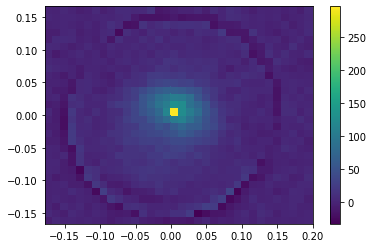

In [40]:
sqrt_PC.FF[5].plot()

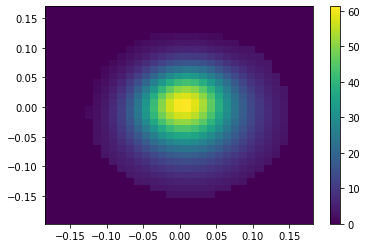

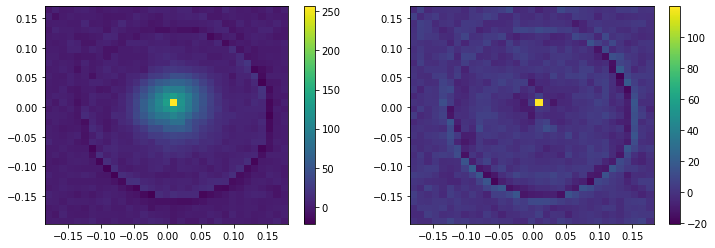

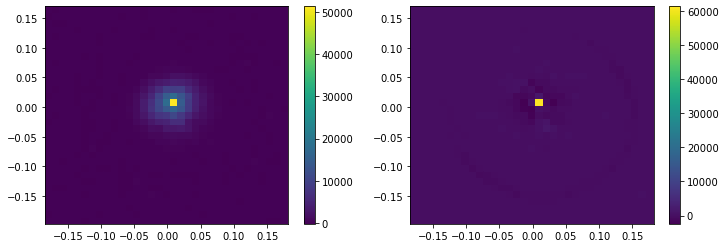

In [60]:
k = 2
Fk = PC.FF[k].translate(all_mu[k,:]-pp[k,:])
sqrt_Fk = convolution_square_root(Fk)

E = BoxFunction(Fk.min, Fk.max, sqrt_Fk.array * sqrt_Fk.array - Fk.array)

Fk.plot()
sqrt_Fk.plot()
E.plot()

getting initial boxes
making conforming boxgrids
making initial meshgrids
making weighting function grid transfer operators:
making Grid2Function transfer operators


  0%|          | 0/140 [00:00<?, ?it/s]

making Function2Grid transfer operators


  0%|          | 0/140 [00:00<?, ?it/s]

making initial impulse response grid transfer operators:
making Grid2Function transfer operators


  0%|          | 0/140 [00:00<?, ?it/s]

making Function2Grid transfer operators


  0%|          | 0/140 [00:00<?, ?it/s]

computing weighting function grid functions


  0%|          | 0/140 [00:00<?, ?it/s]

computing initial impulse response grid functions


  0%|          | 0/140 [00:00<?, ?it/s]

postprocessing impulse responses to fill in boundary nans


  0%|          | 0/140 [00:00<?, ?it/s]

making final impulse response grid transfer operators:
making Grid2Function transfer operators


  0%|          | 0/140 [00:00<?, ?it/s]

making Function2Grid transfer operators


  0%|          | 0/140 [00:00<?, ?it/s]

making convolution grid and transfer operators
making Grid2Function transfer operators


  0%|          | 0/140 [00:00<?, ?it/s]

making Function2Grid transfer operators


  0%|          | 0/140 [00:00<?, ?it/s]

making adjoint convolution grids and functions
running checks
conforming_error_0a= 1.7519848312320392e-17
conforming_error_0b= 1.4304896245381992e-17
conforming_error_1= 4.1252517350920876e-14
conforming_error_2= 4.222352005457961e-14
conforming_error_3= 1.578860494311767e-14
conforming_error_4= 1.1783018260144473e-14
conforming_error_5= 5.320181320155348e-14
conforming_error_6= 3.83051078018465e-14


/home/nick/repos/localpsf/code/localpsf_grid.py:139: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  flipped_F = F[[slice(None, None, -1) for _ in F.shape]]
/home/nick/repos/localpsf/code/localpsf_grid.py:494: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XX, YY, W)
/home/nick/repos/localpsf/code/localpsf_grid.py:545: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and 

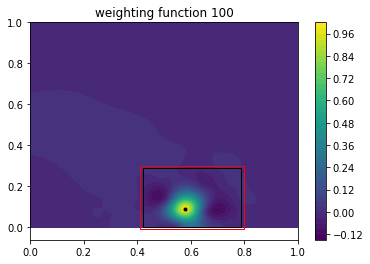

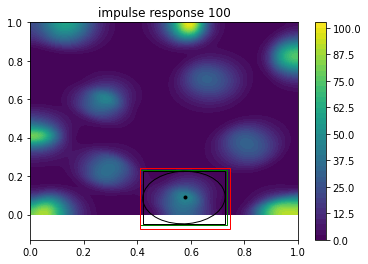

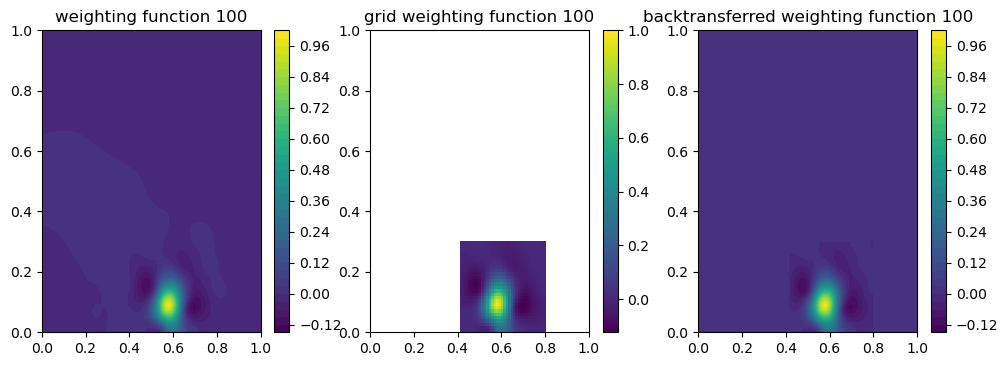

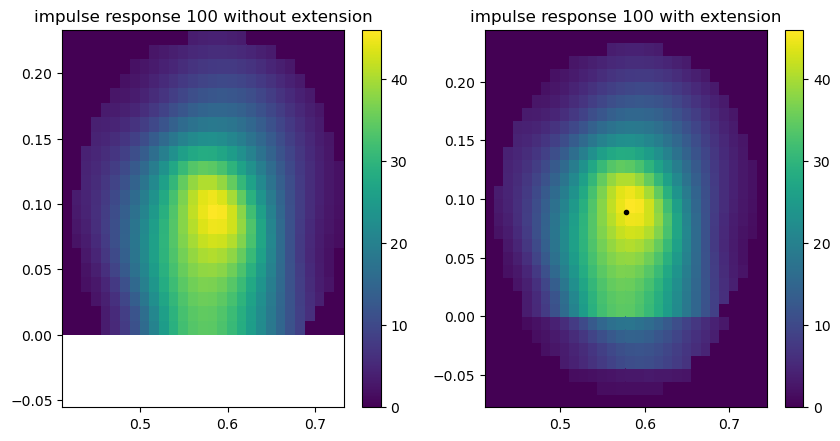

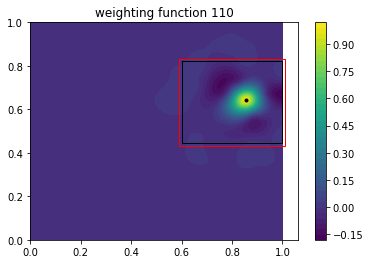

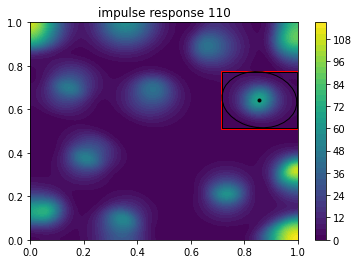

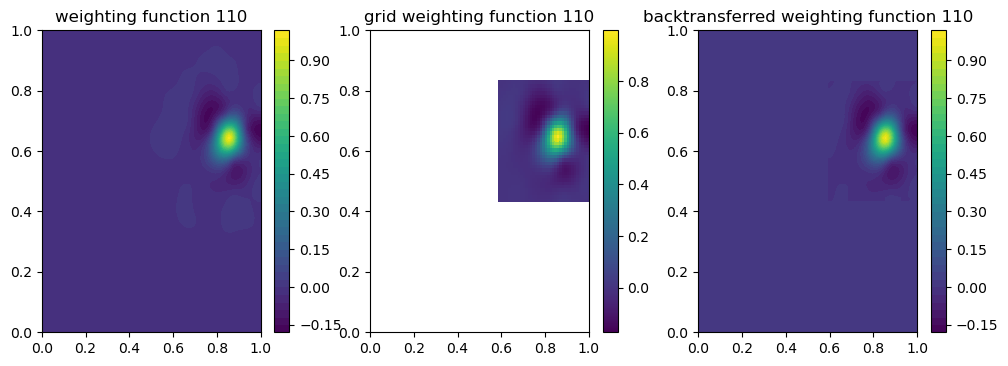

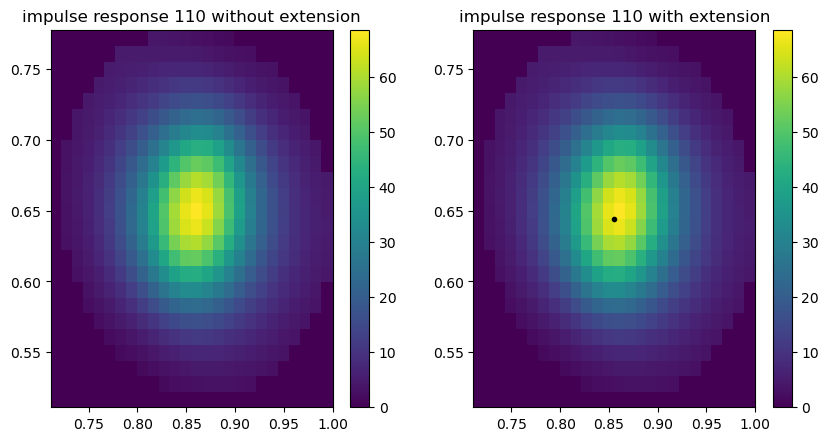

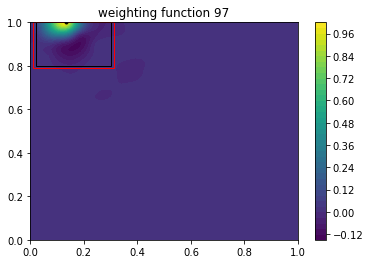

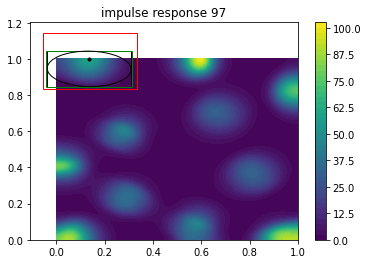

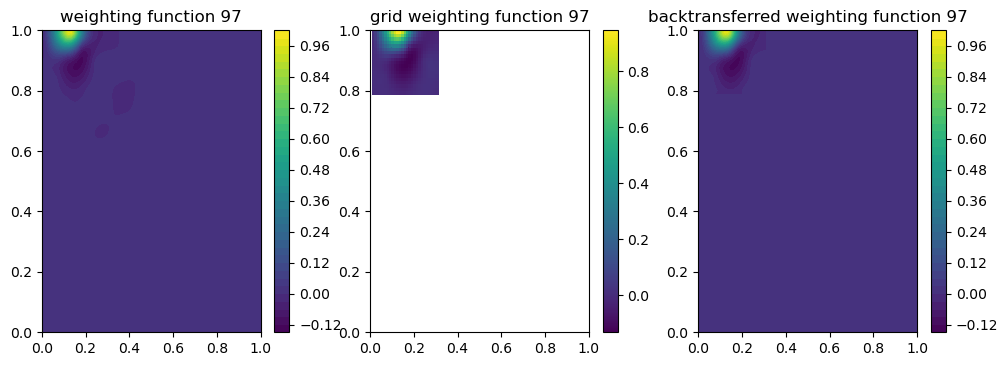

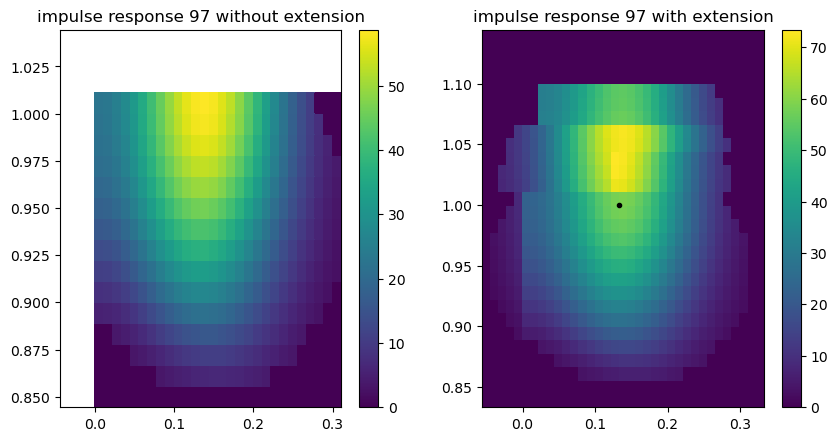

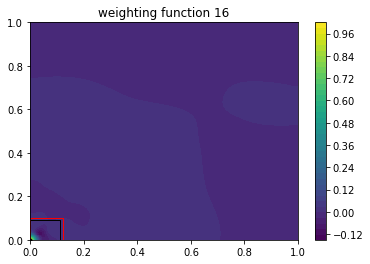

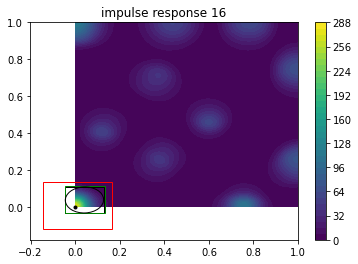

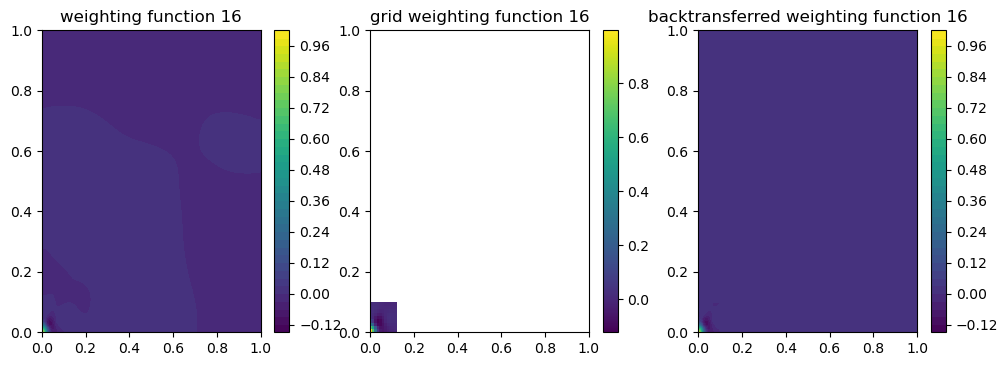

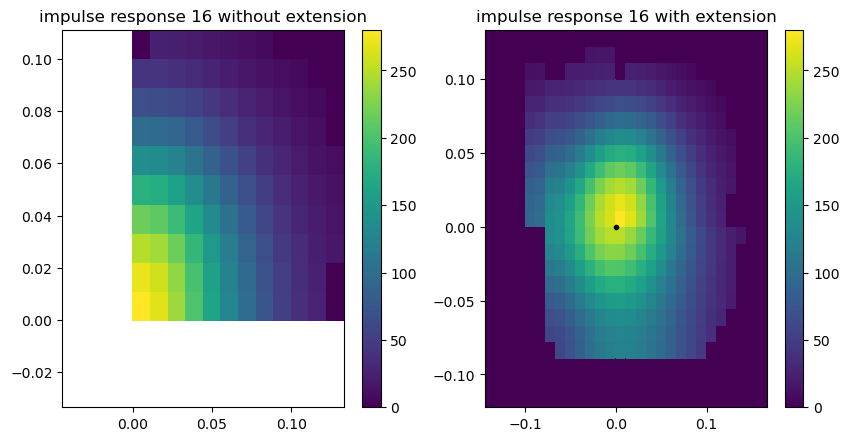

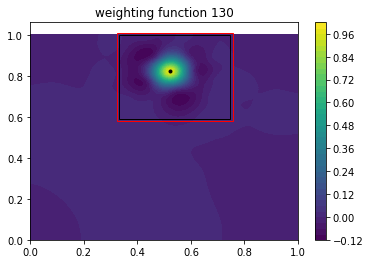

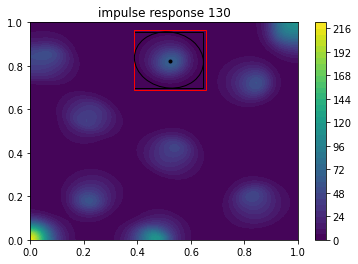

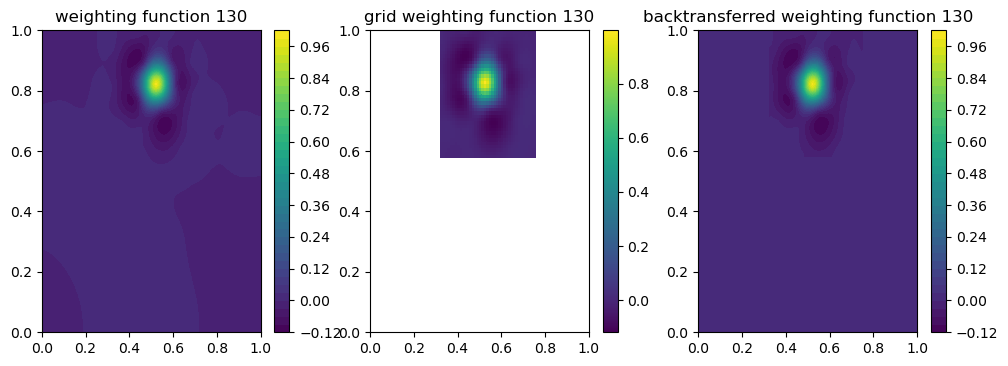

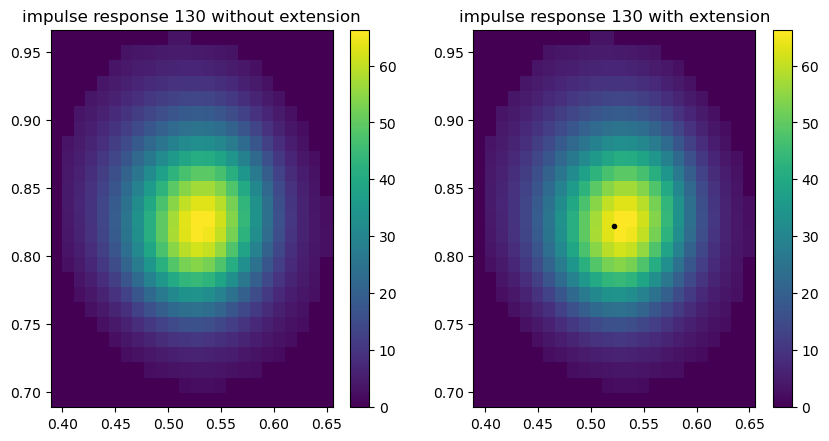

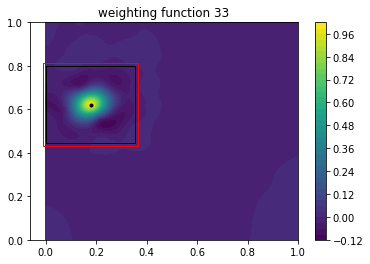

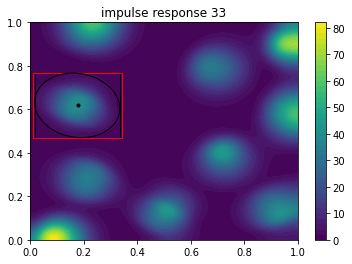

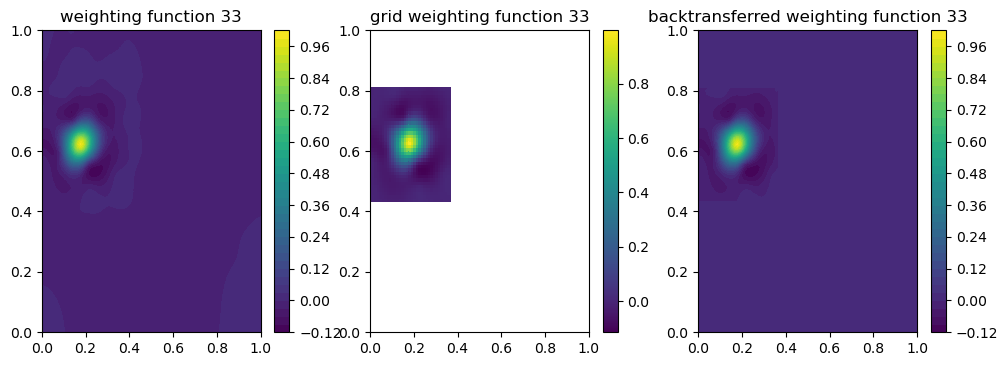

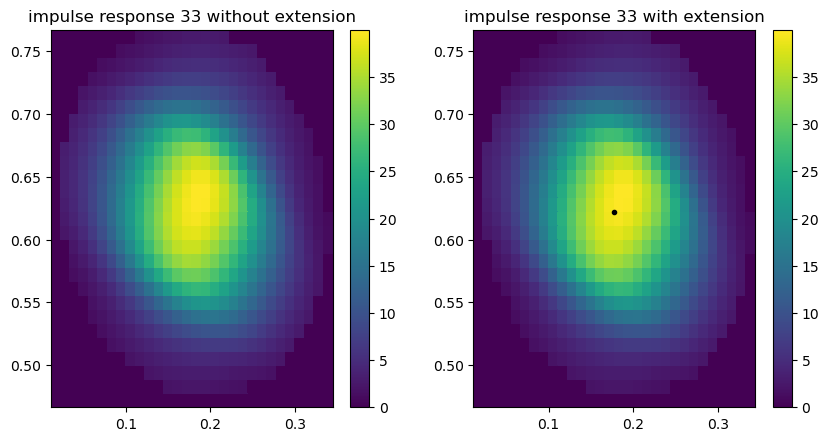

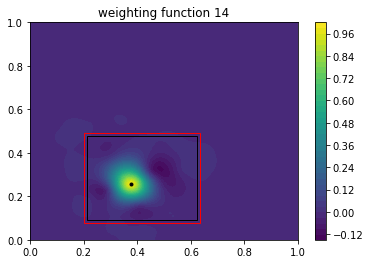

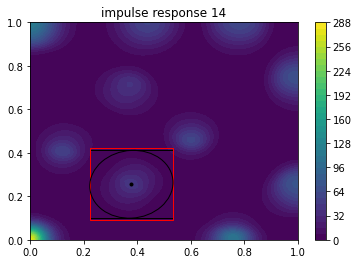

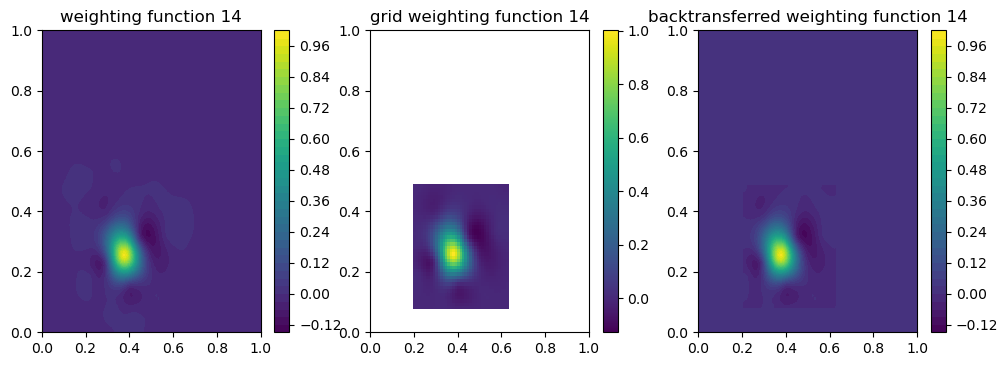

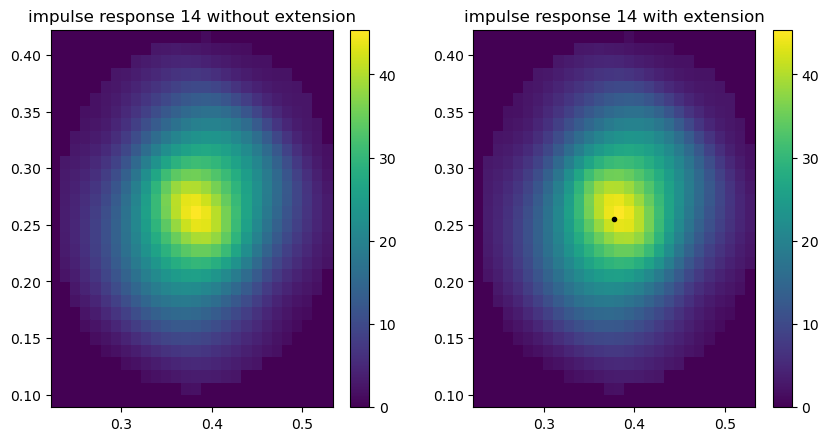

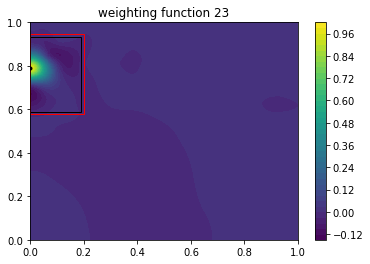

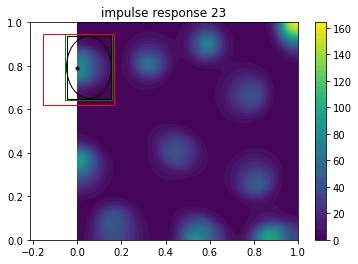

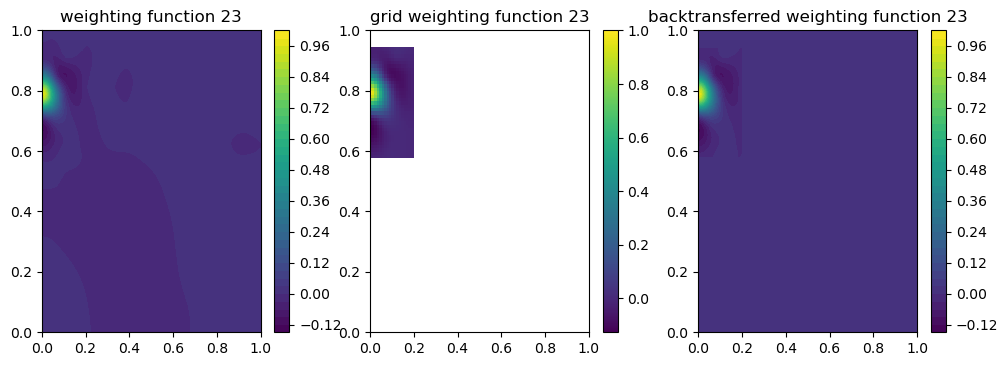

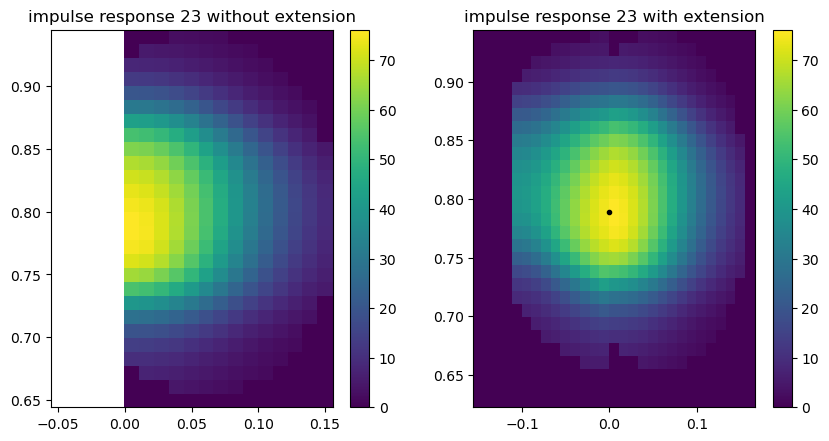

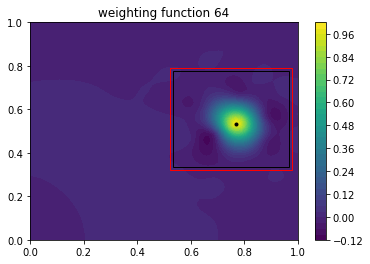

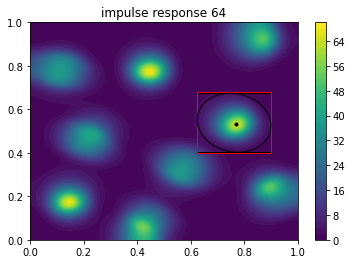

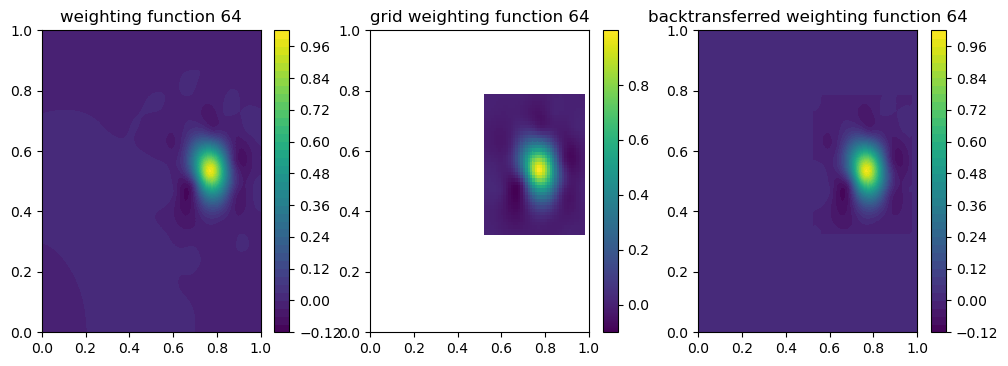

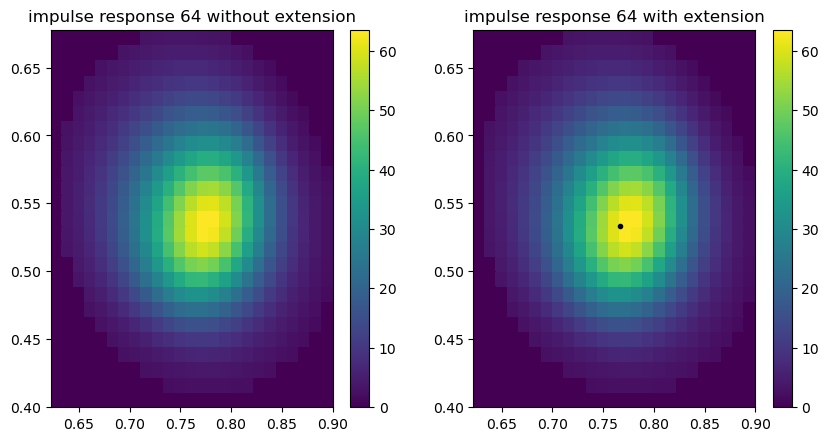

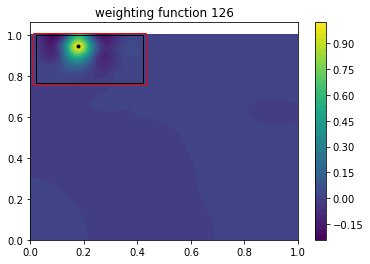

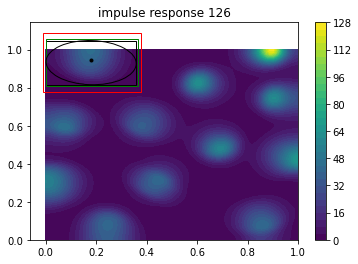

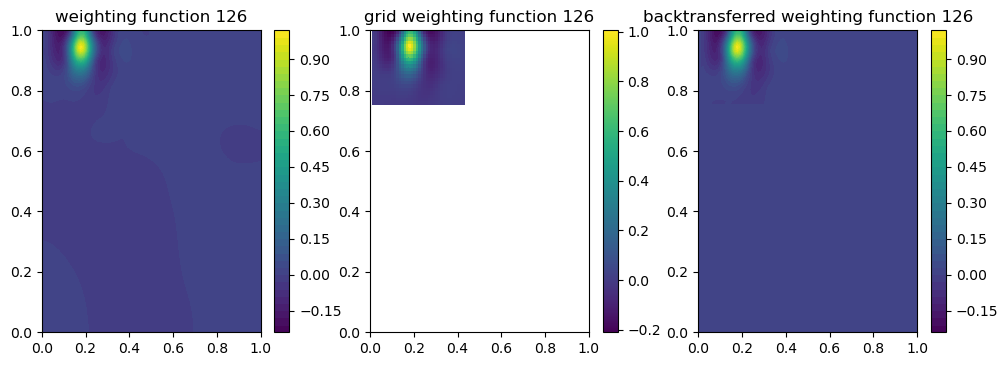

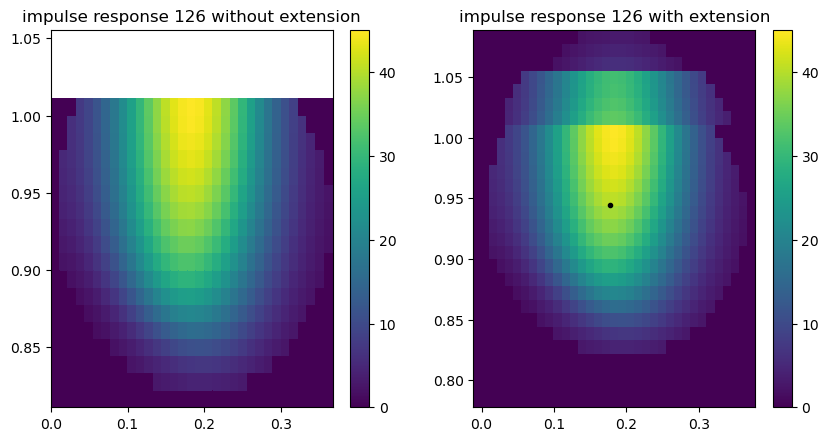

In [50]:
lpsf_grid = LocalPSFGrid(lpsf.weighting_functions,
                         lpsf.dirac_comb_responses,
                         lpsf.point_batches,
                         lpsf.mu_batches, lpsf.Sigma_batches, lpsf.tau)


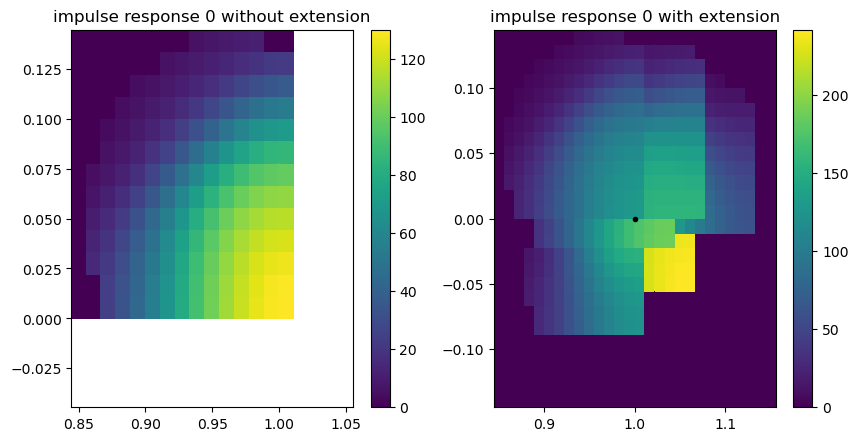

In [51]:
lpsf_grid.make_f_boundary_extension_plot(0)

In [52]:
z = dl.Function(V)
z.vector()[:] = np.random.randn(V.dim())

Text(0.5, 1.0, 'y')

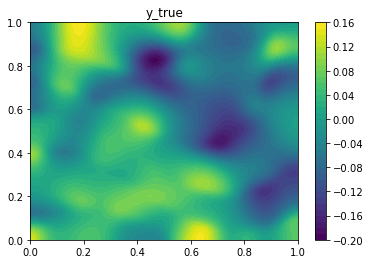

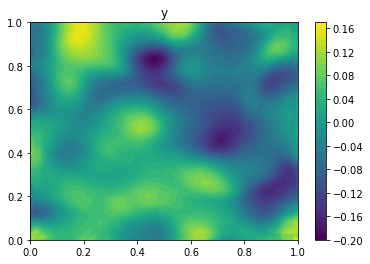

In [53]:
y_true = dl.Function(V)
y_true.vector()[:] = solve_M(apply_Hd(z.vector()))

y = lpsf_grid.matvec(z)

plt.figure()
cm = dl.plot(y_true)
plt.colorbar(cm)
plt.title('y_true')

plt.figure()
cm = dl.plot(y)
plt.colorbar(cm)
plt.title('y')

err_matvec= 0.16979963205787324


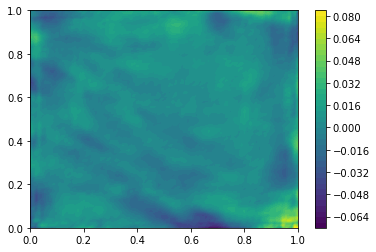

In [54]:
err_matvec = np.linalg.norm(y.vector()[:] - y_true.vector()[:])/np.linalg.norm(y_true.vector()[:])

print('err_matvec=', err_matvec)

ee = dl.Function(V)
ee.vector()[:] = y.vector()[:] - y_true.vector()[:]

cm = dl.plot(ee)
plt.colorbar(cm)

<ipython-input-29-6904c37479d6>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Xi, Yi, Fi)


(-0.04444444444444429, 0.14444444444444393)

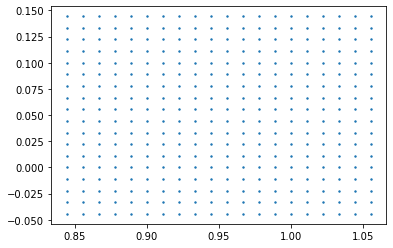

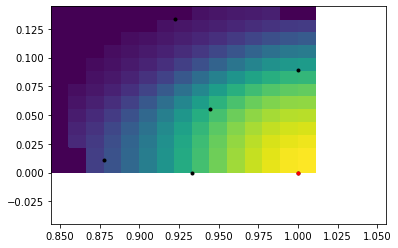

In [29]:
ii = 0
Xi, Yi = lpsf_grid.ff_meshgrids[ii]

plt.figure()
plt.scatter(Xi.reshape(-1), Yi.reshape(-1), s=2)

Fi = lpsf_grid.ff_grid1[ii]

plt.figure()
plt.pcolor(Xi, Yi, Fi)
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(lpsf_grid.pp[:,0], lpsf_grid.pp[:,1], '.k')
plt.plot(lpsf_grid.pp[ii,0], lpsf_grid.pp[ii,1], '.r')
plt.xlim(xlims)
plt.ylim(ylims)

In [44]:
neighbor_inds

array([  0, 103,  61,  91,  30,  39,  80,  15,  17,  71,  47])

In [120]:
pp

array([[0.2, 0.5]])

<ipython-input-158-f43f1a52d6e5>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(all_XXi[0], all_XXi[1], W0_gauss[k,:])
<ipython-input-158-f43f1a52d6e5>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(all_XXi[0], all_XXi[1], W0_gauss[k,:])
<ipython-input-158-f43f1a52d6e5>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilater

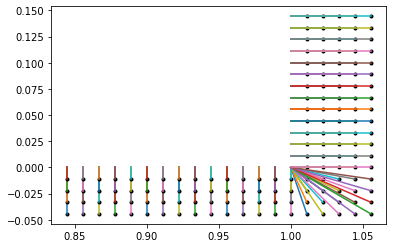

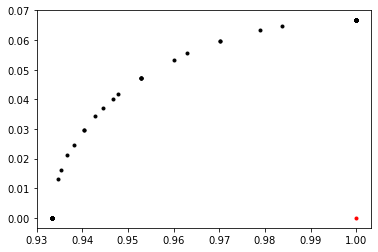

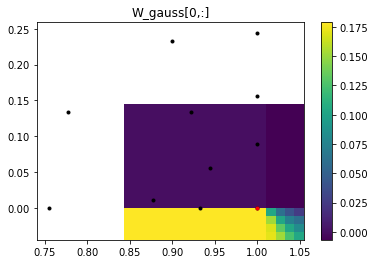

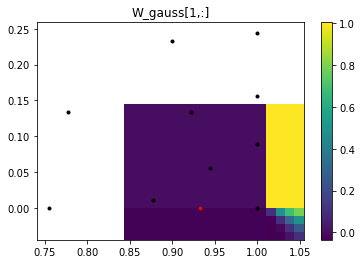

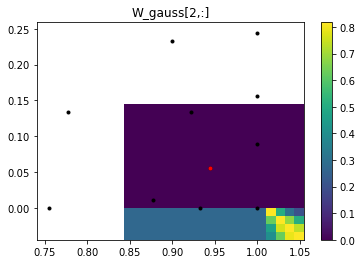

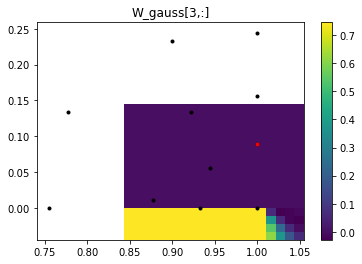

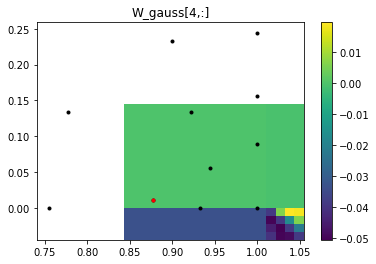

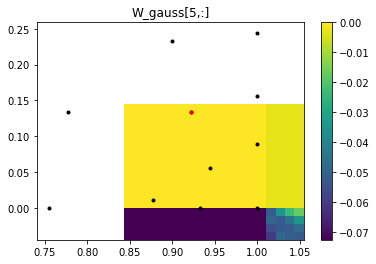

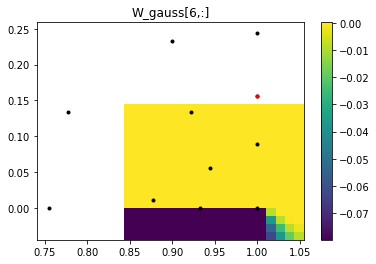

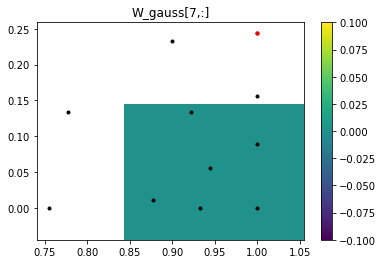

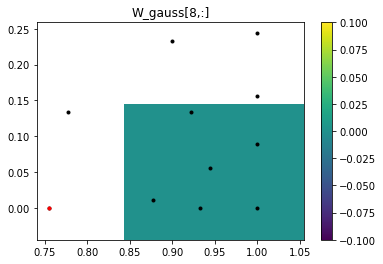

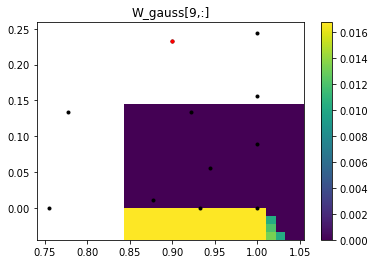

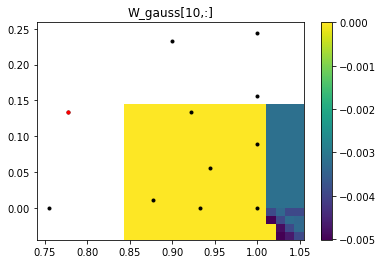

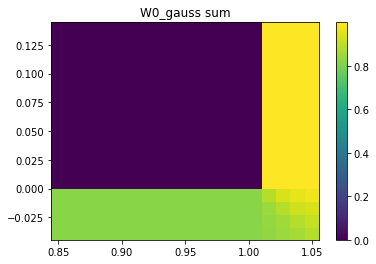

In [158]:
def make_gauss_vectors(pp, ii, all_XXi, Fi, num_neighbors=10, make_plots=True):
    coords_i = np.vstack([X.reshape(-1) for X in all_XXi]).T

    nan_mask = np.isnan(Fi).reshape(-1)
    valid_mask = np.logical_not(nan_mask)

    nan_inds = np.argwhere(nan_mask).reshape(-1)
    valid_inds = np.argwhere(valid_mask).reshape(-1)

    nan_coords = coords_i[nan_inds, :]
    valid_coords = coords_i[valid_inds, :]

    T = cKDTree(valid_coords)
    _, closest_valid_inds = T.query(nan_coords, k=1)

    closest_valid_coords = coords_i[valid_inds[closest_valid_inds],:]
    
    nan_to_domain_vectors = closest_valid_coords - nan_coords
    unit_nan_to_domain_vectors = nan_to_domain_vectors / np.linalg.norm(nan_to_domain_vectors, axis=1).reshape((-1,1))
    
    T_sample = cKDTree(pp)
    dd, neighbor_inds =  T_sample.query(pp[ii,:], num_neighbors + 1)
    nearest_point_distance = dd[1]
    
    gauss_vectors = pp[ii,:].reshape((1,-1)) + nearest_point_distance * unit_nan_to_domain_vectors
    
    if make_plots:
        for jj in range(nan_coords.shape[0]):
            plt.plot(nan_coords[jj,0], nan_coords[jj,1], '.k')
            plt.plot(np.array([nan_coords[jj,0], closest_valid_coords[jj,0]]),
                     np.array([nan_coords[jj,1], closest_valid_coords[jj,1]]))
            
        plt.figure()
        plt.plot(gauss_vectors[:,0], gauss_vectors[:,1], 'k.')
        plt.plot(lpsf_grid.pp[ii,0], lpsf_grid.pp[ii,1], '.r')
    
    return gauss_vectors, nan_inds, neighbor_inds
    

def make_initial_gauss_weighting_functions(grid_shape_i, eval_wi, neighbor_inds, gauss_vectors, nan_inds, pp, all_XXi, make_plots=True):
    num_neighbors = len(neighbor_inds)
    W0_gauss = np.zeros((num_neighbors, np.prod(grid_shape_i)))
    for jj in range(num_neighbors):
        W0_gauss[jj,nan_inds] = eval_wi(neighbor_inds[jj], gauss_vectors)
    W0_gauss = W0_gauss.reshape(tuple([num_neighbors]) + grid_shape_i)
    
    if make_plots:
        for k in range(num_neighbors):
            plt.figure()
            plt.pcolor(all_XXi[0], all_XXi[1], W0_gauss[k,:])
            plt.title('W_gauss['+str(k)+',:]')

            plt.plot(lpsf_grid.pp[neighbor_inds,0], pp[neighbor_inds,1], '.k')
            ii_nbr = neighbor_inds[k]
            plt.plot(pp[ii_nbr,0], pp[ii_nbr,1], '.r')
            plt.colorbar()
    
    return W0_gauss
        
    
gauss_vectors, nan_inds, neighbor_inds = make_gauss_vectors(lpsf_grid.pp, ii, [Xi, Yi], Fi, num_neighbors=10)
W0_gauss = make_initial_gauss_weighting_functions(Fi.shape, lpsf_grid.eval_wi, neighbor_inds, gauss_vectors, nan_inds, lpsf_grid.pp, [Xi, Yi])

    
plt.figure()
plt.pcolor(Xi, Yi, np.sum(W0_gauss[1:,:], axis=0))
plt.title('W0_gauss sum')
plt.colorbar()

In [159]:
def neighbor_box_extension(pp, ff_min, ff_max, hh, ii, neighbor_inds):
    neighbor_mins = pp[ii,:] + (ff_min[neighbor_inds,:] - pp[neighbor_inds,:])
    neighbor_maxes = pp[ii,:] + (ff_max[neighbor_inds,:] - pp[neighbor_inds,:])

    min_new0 = np.min(neighbor_mins, axis=0)
    max_new0 = np.max(neighbor_maxes, axis=0)
    
    min_new, max_new, grid_shape_new = conforming_box(min_new0, max_new0, pp[ii,:], hh[ii,:])
    return min_new, max_new, grid_shape_new

min_i_new, max_i_new, grid_shape_i_new = neighbor_box_extension(lpsf_grid.pp, lpsf_grid.ff_min, lpsf_grid.ff_max, lpsf_grid.hh, ii, neighbor_inds)

print('min_i_new, max_i_new, grid_shape_i_new=', min_i_new, max_i_new, grid_shape_i_new)

_, (Xi_new, Yi_new) = make_regular_grid(min_i_new, max_i_new, grid_shape_i_new)

min_i_new, max_i_new, grid_shape_i_new= [ 0.82222222 -0.16666667] [1.17777778 0.16666667] (33, 31)


<ipython-input-160-d53e30399964>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Xi_new, Yi_new, FF_shifted_neighbors_i_new[k,:])
<ipython-input-160-d53e30399964>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Xi_new, Yi_new, FF_shifted_neighbors_i_new[0,:])


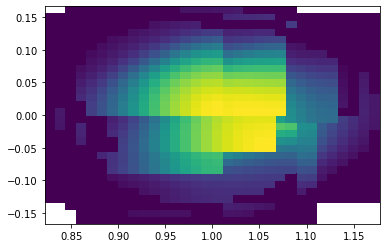

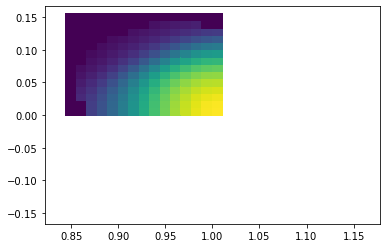

In [160]:
p_i = lpsf_grid.pp[ii,:]

FF_shifted_neighbors_i_new = np.zeros(tuple([len(neighbor_inds)])+grid_shape_i_new)

new_grid_i_coords = np.vstack([Xi_new.reshape(-1), Yi_new.reshape(-1)]).T

for k in range(len(neighbor_inds)):
#     jj = neighbor_inds[::-1][k]
    jj = neighbor_inds[k]
    p_j = lpsf_grid.pp[jj,:]
    F_j = lpsf_grid.ff_grid1[jj]
    min_j = lpsf_grid.ff_min[jj,:] - 1e-12
    max_j = lpsf_grid.ff_max[jj,:] + 1e-12


    Fj_igrid_new = grid_interpolate(p_i + (min_j - p_j), p_i + (max_j - p_j), F_j, new_grid_i_coords, fill_value=np.nan).reshape(Xi_new.shape)

    FF_shifted_neighbors_i_new[k,:] = Fj_igrid_new
    
#     nan_mask = np.isnan(Fj_igrid_new)

plt.figure()
for k in range(len(neighbor_inds))[::-1]:
    plt.pcolor(Xi_new, Yi_new, FF_shifted_neighbors_i_new[k,:])

# plt.pcolor(Xi, Yi, Fi)
plt.figure()
plt.pcolor(Xi_new, Yi_new, FF_shifted_neighbors_i_new[0,:])

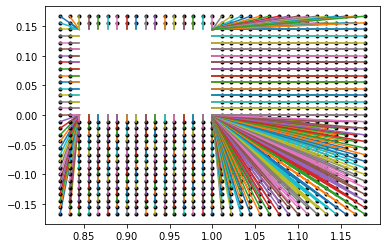

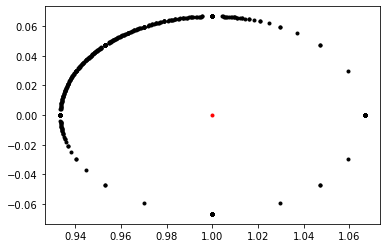

In [161]:
gauss_vectors_new, nan_inds_new, neighbor_inds = make_gauss_vectors(lpsf_grid.pp, ii, [Xi_new, Yi_new], FF_shifted_neighbors_i_new[0,:], num_neighbors=len(neighbor_inds))

In [154]:
neighbor_inds

array([  0, 103,  61,  91,  30,  39,  80,  15,  17,  71,  47,  93])

<ipython-input-158-f43f1a52d6e5>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(all_XXi[0], all_XXi[1], W0_gauss[k,:])
<ipython-input-158-f43f1a52d6e5>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(all_XXi[0], all_XXi[1], W0_gauss[k,:])
<ipython-input-158-f43f1a52d6e5>:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilater

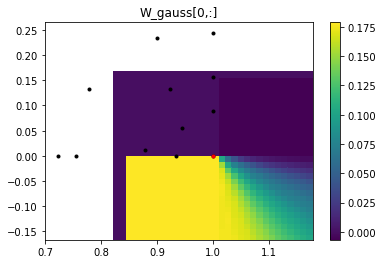

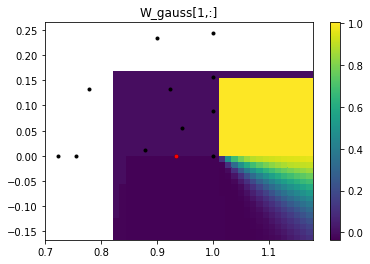

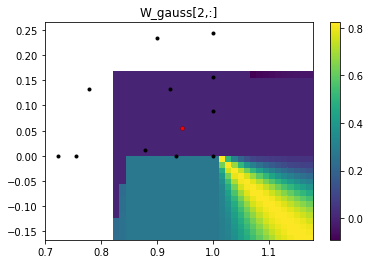

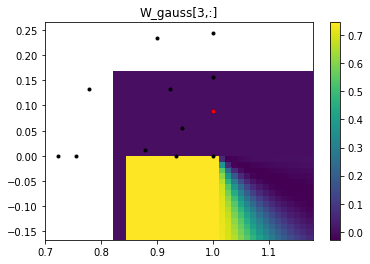

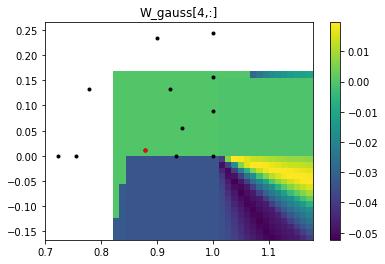

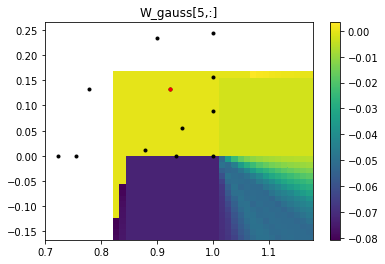

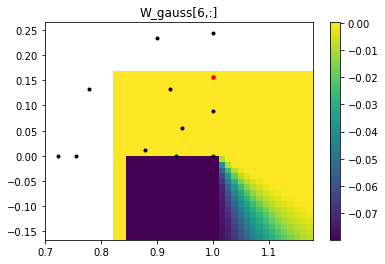

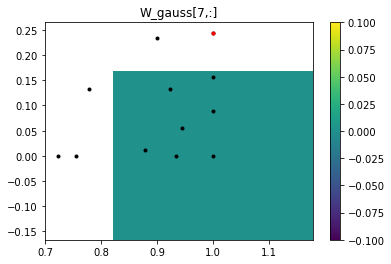

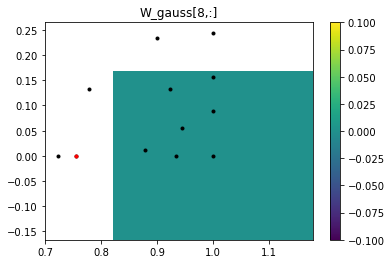

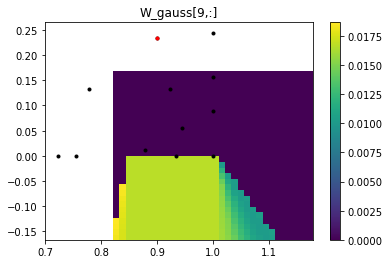

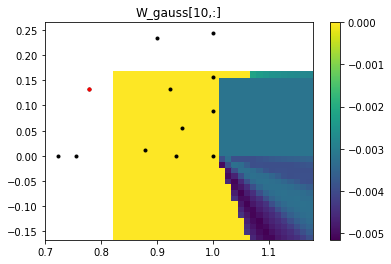

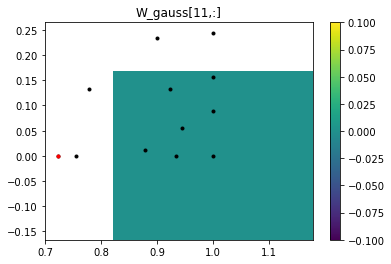

In [162]:
W0_gauss_new = make_initial_gauss_weighting_functions(grid_shape_i_new, lpsf_grid.eval_wi, neighbor_inds, gauss_vectors_new, nan_inds_new, lpsf_grid.pp, [Xi_new, Yi_new])

In [240]:
np.argmax(W0_gauss_new[1:,:], axis=0)

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 4, 4],
       [1, 1, 1, ..., 0, 4, 4],
       [1, 1, 1, ..., 0, 0, 4]])

<ipython-input-227-67c258c91a51>:6: RuntimeWarning: invalid value encountered in true_divide
  W2_gauss_new = W1_gauss_new[1:] / np.sum(W1_gauss_new[1:,:], axis=0).reshape(tuple([1])+W1_gauss_new[1:].shape[1:])
<ipython-input-227-67c258c91a51>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Xi_new, Yi_new, W2_gauss_new[2,:,:])
<ipython-input-227-67c258c91a51>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Xi_new, Yi_new, np.sum(W2_g

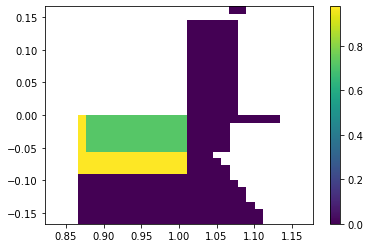

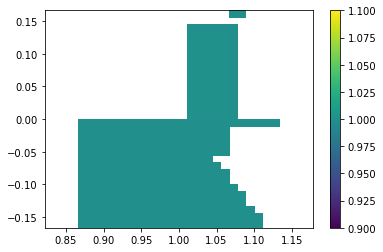

In [227]:
Wa_gauss_new = W0_gauss_new[:-1,:]
Wa_gauss_new[np.isnan(Wa_gauss_new)] = 0.

W1_gauss_new = np.logical_not(np.isnan(FF_shifted_neighbors_i_new)) * Wa_gauss_new * (Wa_gauss_new > 0)

W2_gauss_new = W1_gauss_new[1:] / np.sum(W1_gauss_new[1:,:], axis=0).reshape(tuple([1])+W1_gauss_new[1:].shape[1:])

plt.pcolor(Xi_new, Yi_new, W2_gauss_new[2,:,:])
plt.colorbar()

plt.figure()
plt.pcolor(Xi_new, Yi_new, np.sum(W2_gauss_new, axis=0))
plt.colorbar()

<ipython-input-237-48c40f825353>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Xi_new, Yi_new, FF_combined)
<ipython-input-237-48c40f825353>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Xi_new, Yi_new, FF_shifted_neighbors_i_new[0])


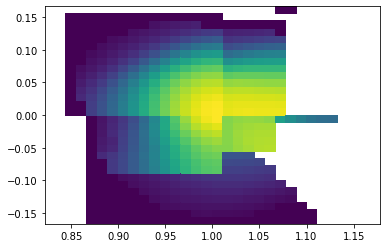

In [237]:
FF_shifted_neighbors0 = FF_shifted_neighbors_i_new[1:]
FF_shifted_neighbors0[np.isnan(FF_shifted_neighbors0)] = 0.0

FF_combined = np.sum(W2_gauss_new * FF_shifted_neighbors_i_new[1:], axis=0)

FF_combined.shape

np.sum(np.isnan(FF_combined)) / np.prod(FF_combined.shape)

plt.pcolor(Xi_new, Yi_new, FF_combined)
plt.pcolor(Xi_new, Yi_new, FF_shifted_neighbors_i_new[0])

In [52]:
grid_interpolate()

_, _, PSI_i = combine_grid_functions([min_i, min_j + pi - pj],
                                   [max_i, max_j + pi - pj],
                                   [PSI_i, PSI_j], expand_box=False)

NameError: name 'min_i' is not defined

<ipython-input-31-65d1097b571d>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Xi, Yi, Fi2)


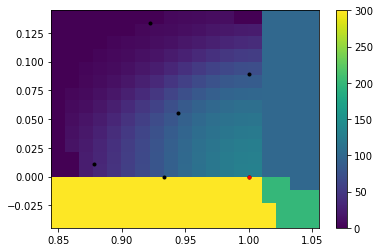

In [31]:

Fi2 = Fi.copy().reshape(-1)
Fi2[nan_inds] = 100*np.argmax(w_gauss, axis=0)
Fi2 = Fi2.reshape(Fi.shape)

plt.figure()
plt.pcolor(Xi, Yi, Fi2)
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(lpsf_grid.pp[:,0], lpsf_grid.pp[:,1], '.k')
plt.plot(lpsf_grid.pp[ii,0], lpsf_grid.pp[ii,1], '.r')
plt.xlim(xlims)
plt.ylim(ylims)
plt.colorbar()

# np.linalg.norm(gauss_vectors - lpsf_grid.pp[ii,:], axis=1) / nearest_point_distance

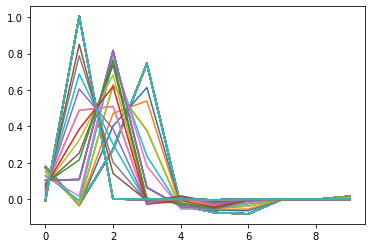

In [32]:
np.sum(w_gauss[1:,:], axis=0)

for jj in range(w_gauss.shape[1]):
    plt.plot(w_gauss[:,jj])

In [ ]:
flipped_nan_coords = 2. * lpsf_grid.pp[ii,:].reshape((1,-1)) - nan_coords


plt.figure()
plt.pcolor(Xi, Yi, Fi)

# print(nan_inds)

# plt.plot(coords_i[:,0], coords_i[:,1], '.k')
# plt.plot(nan_coords[:,0], nan_coords[:,1], '.k')

# for ii in range(coords_i.shape[0]):
#     plt.plot(coords_i[ii,0], coords_i[ii,1], '.k')

for jj in range(nan_coords.shape[0]):
    plt.plot(nan_coords[jj,0], nan_coords[jj,1], '.k')
    plt.plot(np.array([nan_coords[jj,0], flipped_nan_coords[jj,0]]),
             np.array([nan_coords[jj,1], flipped_nan_coords[jj,1]]))

In [ ]:
for ii in range(lpsf_grid.num_pts):
    wi_min = lpsf_grid.ww_min[ii]
    wi_max = lpsf_grid.ww_max[ii]
    Wi = lpsf_grid.ww_grid[ii]
    grid_interpolate()

In [27]:
N = 123456
pp = mesh_center.reshape((1,-1)) + np.random.randn(N, 2)
qq = mesh_center.reshape((1,-1)) + np.random.randn(N, 2)

t = time()
zz_cpp = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(pp, qq)
dt_cpp = time() - t
print('dt_cpp=', dt_cpp)

t = time()
zz_py = lpsf.old_evaluate_approximate_hessian_entries_at_points_yy_xx(pp, qq)
dt_py = time() - t
print('dt_py=', dt_py)

bpc_cpp_err = np.linalg.norm(zz_cpp - zz_py) / np.linalg.norm(zz_py)
print('bpc_cpp_err=', bpc_cpp_err)

dt_cpp= 4.958086013793945
dt_py= 0.8122360706329346
bpc_cpp_err= 0.0


err_Phi2= 0.13998015419413118


Text(0.5, 1.0, 'Phi_true')

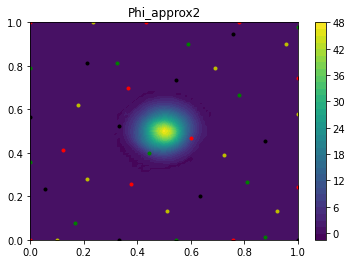

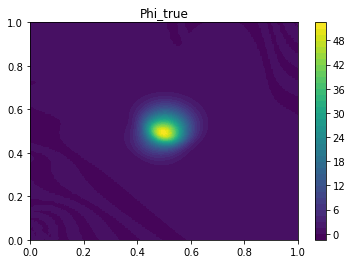

In [28]:
pp = X
q0 = np.array([[0.50,0.50]])
qq = np.dot(np.ones((X.shape[0],1)), q0)

Phi_true = get_hessian_dirac_comb_response(q0, V, apply_Hd, solve_M)

Phi_approx2 = fenics.Function(V)
Phi_approx2.vector()[:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(X, qq)

err_Phi2 = fenics.norm(Phi_approx2.vector() - Phi_true.vector())/fenics.norm(Phi_true.vector())
print('err_Phi2=', err_Phi2)

plt.figure()
cm = fenics.plot(Phi_approx2)
plt.colorbar(cm)
plt.title('Phi_approx2')

# for x in lpsf.PSI.points:
#     plt.plot(x[0], x[1], '.r')
pp = lpsf.point_batches[0]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.k')
    
pp = lpsf.point_batches[1]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.r')
    
pp = lpsf.point_batches[2]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.g')
    
pp = lpsf.point_batches[3]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.y')

plt.figure()
cm = fenics.plot(Phi_true)
plt.colorbar(cm)
plt.title('Phi_true')

In [33]:
ct = hpro.build_cluster_tree_from_dof_coords(X, 60)
hpro.visualize_cluster_tree(ct, "heat_inverse_problem_cluster_tree")

bct = hpro.build_block_cluster_tree(ct, ct, 2.0)
hpro.visualize_block_cluster_tree(bct, "heat_inverse_problem_block_cluster_tree")

# Hd_hmatrix = lpsf.build_hmatrix(bct, tol=1e-8, symmetrize=True)
Hd_hmatrix = lpsf.build_hmatrix(bct, tol=1e-8, symmetrize=False)

hpro.visualize_hmatrix(Hd_hmatrix, "heat_inverse_problem_hmatrix")

In [34]:
interior_ones = np.zeros(V.dim())
interior_ones[lpsf.inds_of_points_far_from_boundary] = 1.
I_int = sps.diags(interior_ones).tocsr()
I_int_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(I_int, bct)

boundary_ones = np.ones(V.dim())
boundary_ones[lpsf.inds_of_points_far_from_boundary] = 0.
I_bnd = sps.diags(boundary_ones).tocsr()
I_bnd_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(I_bnd, bct)

/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [35]:
Hd_hmatrix_xi = Hd_hmatrix * I_int_hmatrix

In [36]:
Hd_hmatrix_T = Hd_hmatrix.T
# Hd_hmatrix_T = Hd_hmatrix_xi.T

In [39]:
z1 = np.random.randn(Hd_hmatrix.shape[1])
z2 = np.random.randn(Hd_hmatrix_T.shape[1])

err_transpose = np.dot(z2, Hd_hmatrix.matvec(z1)) - np.dot(Hd_hmatrix_T.matvec(z2), z1)
print('err_transpose=', err_transpose)

q1 = Hd_hmatrix.matvec(z1)
q2 = Hd_hmatrix_T.matvec(z1)

nonsymmetry = np.linalg.norm(q1-q2)/np.linalg.norm(q1)
print('nonsymmetry=', nonsymmetry)

Hd_hmatrix_sym = Hd_hmatrix.sym(rtol=1e-10)

err_symmetrize = np.dot(z2, Hd_hmatrix_sym.matvec(z1)) - np.dot(Hd_hmatrix_sym.matvec(z2), z1)
print('err_symmetrize=', err_symmetrize)

err_transpose= 8.673617379884035e-19
nonsymmetry= 0.6039897507702315
err_symmetrize= -2.7146313625811547e-13


In [ ]:
Hd_hmatrix_ii = I_int_hmatrix * Hd_hmatrix_xi
Hd_hmatrix_bi = I_bnd_hmatrix * Hd_hmatrix_xi

Hd_hmatrix_sym_noboundary = Hd_hmatrix_bi + Hd_hmatrix_bi.T + Hd_hmatrix_ii.sym()
# Hd_hmatrix_sym_noboundary = Hd_hmatrix_ii.sym()

# Hd_hmatrix_nonsym = Hd_hmatrix

# Hd_hmatrix = Hd_hmatrix_sym_noboundary

In [ ]:
Hd_hmatrix = Hd_hmatrix_sym
# Hd_hmatrix =  Hd_hmatrix_nonsym

In [ ]:
z = fenics.Function(V)
z.vector()[:] = np.random.randn(X.shape[0])

v = fenics.Function(V)
# v.vector()[:] = hpro.hmatrix_matvec(A_hmatrix, ct, ct, (M * z.vector())[:])
v.vector()[:] = Hd_hmatrix * z.vector()[:]
v.vector()[:] = solve_M(v.vector())

v2 = fenics.Function(V)
v2.vector()[:] = solve_M(apply_Hd(z.vector()))

err_hmatvec = np.linalg.norm(v.vector()[:] - v2.vector()[:])/np.linalg.norm(v2.vector()[:])
print('err_hmatvec=', err_hmatvec)

cm1 = fenics.plot(v)
plt.colorbar(cm1)
plt.title('hmatrix matvec')

plt.figure()
cm2 = fenics.plot(v2)
plt.colorbar(cm2)
plt.title('regular hessian matvec')

plt.figure()
cm3 = fenics.plot(v2 - v)
plt.colorbar(cm3)
plt.title('error (difference)')

In [ ]:
def convert_fenics_csr_matrix_to_scipy_csr_matrix(A_fenics):
    ai, aj, av = fenics.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

In [ ]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)
k_form = fenics.inner(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx
K = fenics.assemble(k_form)

K_csc = convert_fenics_csr_matrix_to_scipy_csr_matrix(K)
M_csc = convert_fenics_csr_matrix_to_scipy_csr_matrix(M)

R_csc = K_csc + 1e0*M_csc

In [ ]:
M_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(M_csc, bct)
R_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(R_csc, bct)

hpro.visualize_hmatrix(M_hmatrix, "heat_inverse_problem_R_hmatrix")

In [ ]:
x = np.random.randn(V.dim())
y1 = R_csc * x
y2 = R_hmatrix * x
err_R_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y1)
print('err_R_hmatrix=', err_R_hmatrix)

In [ ]:
x = np.random.randn(V.dim())
y1 = M_csc * x
y2 = M_hmatrix * x
err_M_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y1)
print('err_M_hmatrix=', err_M_hmatrix)

In [ ]:
def apply_H(x_vec):
    x = fenics.Function(V)
    x.vector()[:] = x_vec
    y_vec = apply_Hd(x.vector())[:] + a_reg*(R_csc*x_vec)
    return y_vec

H_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_H)

In [ ]:
R_scale_err = np.linalg.norm((a_reg * R_hmatrix) * x - a_reg * R_csc * x)
print('R_scale_err=', R_scale_err)

In [ ]:
H_hmatrix = Hd_hmatrix + a_reg * R_hmatrix

hpro.visualize_hmatrix(H_hmatrix, "heat_inverse_problem_H_hmatrix_sym")

In [ ]:
x = np.random.randn(V.dim())
y1 = H_hmatrix * x
y2 = Hd_hmatrix * x + a_reg * (R_csc * x)
np.linalg.norm(y2-y1)/np.linalg.norm(y2)

In [ ]:
iH_hmatrix = H_hmatrix.factorized_inverse()

In [ ]:
err_H_matrix_factorization = np.linalg.norm(x - H_hmatrix * iH_hmatrix.matvec(x))/np.linalg.norm(x)
print('err_H_matrix_factorization=', err_H_matrix_factorization)

In [ ]:
krylov_iter=20
krylov_tol=1e-12

# Hfull_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_H)

solve_R = spla.factorized(a_reg * R_csc)
solve_R_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=solve_R)

b = np.random.randn(V.dim())
# x_true = np.linalg.solve(H_true, b)

x_none = spla.gmres(H_linop, b, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_none = np.linalg.norm(apply_H(x_none) - b)/np.linalg.norm(b)
print('err_none=', err_none)

x_R = spla.gmres(H_linop, b, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_reg = np.linalg.norm(apply_H(x_R) - b)/np.linalg.norm(b)
print('err_reg=', err_reg)

x_pre = spla.gmres(H_linop, b, M=iH_hmatrix, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_pre = np.linalg.norm(apply_H(x_pre) - b)/np.linalg.norm(b)
print('err_pre=', err_pre)

In [ ]:
z0 = fenics.Function(V)

g_dual = gradient(z0.vector())
g = g_dual[:]
g_reisz = fenics.Function(V)
g_reisz.vector()[:] = solve_M(g_dual)

fenics.plot(u0_true, cmap='gray')
plt.title('u0_true')

plt.figure()
fenics.plot(-g_reisz, cmap='gray')
plt.title('-gradient at zero')

In [ ]:
u0_exact = spla.gmres(H_linop, -g, M=iH_hmatrix, restart=50, maxiter=1, tol=krylov_tol)[0]
u0_err_exact = np.linalg.norm(apply_H(u0_exact) + g)/np.linalg.norm(g)
print('u0_err_exact=', u0_err_exact)

u0_exact_fct = fenics.Function(V)
u0_exact_fct.vector()[:] = u0_exact
cm = fenics.plot(u0_exact_fct, cmap='gray')
plt.colorbar(cm)
plt.title('u0_exact_fct')

uf_fct = fenics.Function(V)
uf_fct.vector()[:] = forward_map(u0_exact_fct.vector())

uf_true_fct = fenics.Function(V)
uf_true_fct.vector()[:] = forward_map(u0_true.vector())

plt.figure()
fenics.plot(uT_true, cmap='gray')
plt.title('uT_true')

In [ ]:
morozov_discrepancy = np.sqrt(fenics.assemble((uf_true_fct - uf_fct)**2 * fenics.dx))

obs_norm = np.sqrt(fenics.assemble(uf_true_fct**2 * fenics.dx))

morozov_relative_noise_level = morozov_discrepancy / obs_norm
# morozov_discrepancy = np.sqrt(2.0 * objective(u0_exact_fct.vector()))

# fenics.assemble(uf_true_fct * fenics.dx)
#
# morozov_discrepancy2 = np.linalg.norm(uf_true[:] - uf[:])/np.linalg.norm(uf_true[:])

print('morozov_discrepancy=', morozov_discrepancy, ', obs_norm=', obs_norm)
print('morozov_relative_noise_level=', morozov_relative_noise_level)

In [ ]:
krylov_iter=15
krylov_tol=1e-12

u0_none = spla.gmres(H_linop, -g, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_none = np.linalg.norm(apply_H(u0_none) + g)/np.linalg.norm(g)
print('u0_err_none=', u0_err_none)

u0_R = spla.gmres(H_linop, -g, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_reg = np.linalg.norm(apply_H(u0_R) + g)/np.linalg.norm(g)
print('u0_err_reg=', u0_err_reg)

u0_pre = spla.gmres(H_linop, -g, M=iH_hmatrix, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_pre = np.linalg.norm(apply_H(u0_pre) + g)/np.linalg.norm(g)
print('u0_err_pre=', u0_err_pre)

plt.figure()
u0_none_fct = fenics.Function(V)
u0_none_fct.vector()[:] = u0_none
fenics.plot(u0_none_fct, cmap='gray')
plt.title('u0_none_fct')

plt.figure()
u0_R_fct = fenics.Function(V)
u0_R_fct.vector()[:] = u0_R
fenics.plot(u0_R_fct, cmap='gray')
plt.title('u0_R_fct')

plt.figure()
u0_pre_fct = fenics.Function(V)
u0_pre_fct.vector()[:] = u0_pre
fenics.plot(u0_pre_fct, cmap='gray')
plt.title('u0_pre_fct')

In [ ]:
Z_linop = spla.LinearOperator(H_linop.shape, matvec=lambda x:H_linop.matvec(x) - H_hmatrix.matvec(x))
#
# dd, P = spla.eigsh(Z_linop, k=6, M=H_hmatrix_sym, Minv=H_hmatrix_sym_factorized, mode='buckling', which='LM')

A_linop = spla.LinearOperator(Z_linop.shape,
                              matvec=lambda x:iH_hmatrix.matvec(H_linop.matvec(x))-x,
                              rmatvec=lambda x: H_linop.matvec(iH_hmatrix.matvec(x))-x)

AR_linop = spla.LinearOperator(Z_linop.shape,
                              matvec=lambda x:solve_R_linop.matvec(H_linop.matvec(x))-x,
                              rmatvec=lambda x: H_linop.matvec(solve_R_linop.matvec(x))-x)

# _,ss,_ = spla.svds(Q_linop, k=6, which='LM')

_,ss,_ = basic_randomized_svd(A_linop, 100)
_,ssR,_ = basic_randomized_svd(AR_linop, 100)

$$P^{-1} H - I = U \Sigma V^T$$

$$P$$ is either $R$ or our preconditioner

In [ ]:
plt.figure()
plt.semilogy(ss)
plt.semilogy(ssR)
plt.legend(['ss', 'ssR'])
plt.title('preconditioned singular values')

In [ ]:
ss

In [ ]:
Happrox_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
#     print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    Happrox_dense[k,:] = Hfull_hmatrix * ek

In [ ]:
plt.matshow(Happrox_dense)

In [ ]:
H_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    H_dense[k,:] = apply_Hfull(ek)

In [ ]:
np.linalg.norm(Happrox_dense - H_dense)/np.linalg.norm(H_dense)

In [ ]:
invH_hmatrix = hpro.convert_sparse_csc_matrix_to_hmatrix(a_reg*R_csc, ct, ct, bct)
hpro.hmatrix_add_overwrites_second(A_hmatrix, invH_hmatrix, 1e-6)
hpro.hmatrix_factorized_inverse_destructive(invH_hmatrix, 1e-6)

def apply_invH_approx(x_vec):
    x = fenics.Function(V)
    x.vector()[:] = x_vec

    iHMx = fenics.Function(V)
    iHMx.vector()[:] = hpro.hmatrix_matvec(invH_hmatrix, ct, ct, (M * x.vector())[:])
    return (M * iHMx.vector())[:]

apply_invH_approx_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_invH_approx)

In [ ]:
iH_dense = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
#     print('k=', k)
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    iH_dense[k,:] = apply_invH_approx(ek)

In [ ]:
plt.matshow(H_dense - a_reg*R_csc.toarray())

In [ ]:
_,ss,_ = np.linalg.svd(G)
ss
plt.semilogy(ss)

In [ ]:

# x2 = hpro.hmatrix_factorized_inverse_matvec(inv_A, ct, ct, y)

In [ ]:
ek = fenics.Function(V).vector()
A_true = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    ek[:] = 0.
    ek[k] = 1.
    A_true[:,k] = apply_H(ek)[:]

In [ ]:
plt.matshow(A_true)

In [ ]:
iM_A_iM = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    q0 = X[k,:].reshape((1,-1))
    qq = np.dot(np.ones((V.dim(),1)), q0)
    iM_A_iM[k,:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(X, qq)[:]
    

In [ ]:
M_numpy = M.array()
A_approx = np.dot(M_numpy, np.dot(iM_A_iM, M_numpy))
# A_approx = np.dot(M_numpy, iM_A_iM)

In [ ]:
plt.matshow(A_approx)

In [ ]:
np.linalg.norm(A_approx - A_true)/np.linalg.norm(A_true)

In [ ]:
PI.gaussian_kernel_widths

In [ ]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)
k_form = fenics.inner(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx
K = fenics.assemble(k_form)
K_numpy = K.array()

Reg = K_numpy + 1e0*M_numpy

_,ssM,_ = np.linalg.svd(M_numpy)
_,ssK,_ = np.linalg.svd(K_numpy)
_,ssR,_ = np.linalg.svd(Reg)

plt.semilogy(ssM)
plt.semilogy(ssK)
plt.semilogy(ssR)
plt.legend(['M', 'K', 'R'])

In [ ]:
a_reg = 2e-5
H_true = A_true + a_reg * Reg
H_true = (H_true + H_true.T)/2.
H_approx0 = A_approx + a_reg * Reg
H_approx = (H_approx0 + H_approx0.T)/2.

In [ ]:
U,ss_true,_ = np.linalg.svd(A_true)
ss_approx = np.abs(np.diagonal(np.dot(U.T,np.dot(A_approx,U))))
ss_reg = np.diagonal(np.dot(U.T,np.dot(Reg,U)))

In [ ]:
plt.semilogy(ss_true[:500])
plt.semilogy(ss_approx[:500])
plt.semilogy(a_reg*ss_reg[:500])
plt.legend(['A_true', 'A_approx', 'Reg'])
plt.xlabel('i')
plt.ylabel('lambda_i')

In [ ]:
H_pre = np.linalg.solve(H_approx, H_true)
_,ss_pre,_ = np.linalg.svd(H_pre)

H_preR = np.linalg.solve(a_reg * Reg, H_true)
_,ss_preR,_ = np.linalg.svd(H_preR)

In [ ]:
plt.figure()
plt.semilogy(ss_pre)
plt.semilogy(ss_preR)
plt.legend(['H_pre', 'H_preR'])
plt.xlabel('i')
plt.ylabel('lambda_i')

cond_pre = np.max(ss_pre)/np.min(ss_pre)
cond_preR = np.max(ss_preR)/np.min(ss_preR)

print('cond_pre=', cond_pre)
print('cond_preR=', cond_preR)

## Random RHS

In [ ]:
krylov_iter=20
krylov_tol=1e-12

b = np.random.randn(V.dim())
x_true = np.linalg.solve(H_true, b)

x_R = spla.gmres(H_true, b, M=np.linalg.inv(Reg), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_reg = np.linalg.norm(x_true - x_R)/np.linalg.norm(x_true)
print('err_reg=', err_reg)

x_pre = spla.gmres(H_true, b, M=np.linalg.inv(H_approx), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_pre = np.linalg.norm(x_true - x_pre)/np.linalg.norm(x_true)
print('err_pre=', err_pre)

## Gradient RHS

### Try deflating spectrum

In [ ]:
H_pre2 = np.linalg.solve(H_approx, H_true)
U,ss,Vt = np.linalg.svd(H_pre2 - np.eye(V.dim()))

In [ ]:
r2 = 5
plt.semilogy(ss)
np.sum(ss > r2)

In [ ]:
P = H_approx2
delta_P = np.dot(P, np.dot(U[:,:r2], np.dot(np.diag(ss[:r2]), Vt[:r2,:])))
P2 = P + delta_P
H_pre3 = np.linalg.solve(P2, H_true)

In [ ]:
_,ll0,_ = np.linalg.svd(H_true)
_,ll1,_ = np.linalg.svd(P)
_,ll2,_ = np.linalg.svd(P2)

plt.semilogy(ll0)
plt.semilogy(ll1)
plt.semilogy(ll2)

In [ ]:
e0 = np.linalg.norm(P - H_true)/np.linalg.norm(H_true)
e1 = np.linalg.norm(P2 - H_true)/np.linalg.norm(H_true)
print('e0=', e0)
print('e1=', e1)

In [ ]:
import scipy.sparse.linalg as spla

# b_form = fenics.Expression('sin(5*x[0])*cos(3*x[1]) + x[0]*x[1]', degree=1)*fenics.TestFunction(V)*fenics.dx
# b = fenics.assemble(b_form)[:]
# b = np.random.randn(V.dim())
b = np.dot(H_true, ww[1].vector()[:])
b_fct = fenics.Function(V)
b_fct.vector()[:] = np.linalg.solve(M_numpy, b)
x_true = np.linalg.solve(H_true, b)

x_approx = np.linalg.solve(H_approx2, b)
x_approx3 = np.linalg.solve(P2, b)

err_approx = np.linalg.norm(x_true - x_approx)/np.linalg.norm(x_true)
print('err_approx=', err_approx)

err_approx3 = np.linalg.norm(x_true - x_approx3)/np.linalg.norm(x_true)
print('err_approx3=', err_approx3)

x_true_fct = fenics.Function(V)
x_true_fct.vector()[:] = x_true

x_approx_fct = fenics.Function(V)
x_approx_fct.vector()[:] = x_approx

x_approx3_fct = fenics.Function(V)
x_approx3_fct.vector()[:] = x_approx3

fenics.plot(x_true_fct)
plt.figure()
fenics.plot(x_approx_fct)
plt.figure()
fenics.plot(x_approx3_fct)

In [ ]:
fenics.plot(b_fct)

In [ ]:
iter = 20
krylov_tol = 1e-12

x0 = spla.gmres(H_true, b, restart=iter, maxiter=1, tol=krylov_tol)[0]
# x0 = spla.gmres(H_true, b, maxiter=iter)[0]
err0 = np.linalg.norm(x_true - x0)/np.linalg.norm(x_true)
# err0 = np.linalg.norm(np.dot(H_true,x0) - b)/np.linalg.norm(b)
print('err0=', err0)

x1 = spla.gmres(H_true, b, M=np.linalg.inv(Reg), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x1 = spla.gmres(H_true, b, M=np.linalg.inv(Reg), maxiter=iter)[0]
# x1 = spla.minres(H_true, b, M=Reg, maxiter=iter)[0]
# x1 = spla.gmres(H_true, b, M=Reg, maxiter=iter)[0]
err1 = np.linalg.norm(x_true - x1)/np.linalg.norm(x_true)
# np.linalg.norm(np.dot(H_true,x1) - b)/np.linalg.norm(b)
print('err1=', err1)

x2 = spla.gmres(H_true, b, M=np.linalg.inv((H_approx+H_approx.T)/2.), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x2 = spla.gmres(H_true, b, M=np.linalg.inv((P2+P2.T)/2.), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x2 = spla.minres(H_true, b, M=np.linalg.inv(H_approx2), maxiter=iter)[0]
# x2 = spla.gmres(H_true, b, M=np.linalg.inv(H_approx2), restart=iter, maxiter=1)[0]
# x2 = spla.minres(H_true, b, M=H_approx2, maxiter=iter)[0]
# x2 = spla.gmres(H_true, b, M=H_approx2, maxiter=iter)[0]
err2 = np.linalg.norm(x_true - x2)/np.linalg.norm(x_true)
# np.linalg.norm(np.dot(H_true,x2) - b)/np.linalg.norm(b)
print('err2=', err2)

x1_fct = fenics.Function(V)
x1_fct.vector()[:] = x1

fenics.plot(x1_fct)
plt.title('x1_fct')

plt.figure()
x2_fct = fenics.Function(V)
x2_fct.vector()[:] = x2

cm = fenics.plot(x2_fct)
plt.title('x2_fct')
plt.colorbar(cm)

plt.figure()
cm = fenics.plot(x_true_fct - x1_fct)
plt.colorbar(cm)
plt.title('err1 function')

plt.figure()
cm = fenics.plot(x_true_fct - x2_fct)
plt.colorbar(cm)
plt.title('err2 function')

In [ ]:
err0

In [ ]:
point_batches = list()
dirac_comb_responses = list()
dirac_comb_response_evaluators = list()
mu_batches = list()
Sigma_batches = list()
PSI = PoissonSquaredInterpolation(V)

def add_new_batch():
    new_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
    new_points = candidate_points[new_batch_inds, :]
    point_batches.append(new_points)
    candidate_inds = list(np.setdiff1d(candidate_inds, new_inds))

    mu_batches.append(eval_mu(new_points))
    all_Sigma_batches.append(eval_Sigma(new_points))
    
    new_dirac_comb_response = get_dirac_comb_response(new_batch_points)
    dirac_comb_responses.append(new_dirac_comb_response)
    dirac_comb_response_evaluators.append(FenicsFunctionFastGridEvaluator(new_dirac_comb_response))
    
    PSI.add_points([new_points[k,:] for k in range(new_points.shape[0])])
    

In [ ]:
PSI = PoissonSquaredInterpolation(V)

In [ ]:
latest_batch_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
latest_batch_of_points = candidate_points[latest_batch_inds, :]

latest_mu_batch = eval_mu(latest_batch_of_points)
all_mu_batches.append(latest_mu_batch)

latest_Sigma_batch = eval_Sigma(latest_batch_of_points)
all_Sigma_batches.append(latest_Sigma_batch)

In [ ]:
latest_eta = fenics.Function(V)
latest_eta.vector()[:] = get_dirac_comb_response(latest_batch_of_points)
all_eta.append(latest_eta)

latest_eval_eta = FenicsFunctionFastGridEvaluator(latest_eta)
all_eval_eta.append(latest_eval_eta)

In [ ]:
PSI.add_points([latest_batch_of_points[k,:] for k in range(latest_batch_of_points.shape[0])])

In [ ]:
for k in range(latest_batch_of_points.shape[0]):
    plt.figure()
    cmap = fenics.plot(PSI.weighting_functions[k])
    plt.plot(latest_batch_of_points[k,0], latest_batch_of_points[k,1],'.')
    plt.colorbar(cmap)

In [ ]:
all_eval_ww = [FenicsFunctionFastGridEvaluator(w) for w in PSI.weighting_functions]

In [ ]:
all_batches_of_points.append(latest_batch_of_points)
all_eta.append(latest_eta)
candidate_inds = list(np.setdiff1d(candidate_inds, latest_batch_inds))

me.BPC = BatchProductConvolution(me.all_eval_eta, me.all_eval_ww,
                                 me.all_batches_of_points, me.all_mu_batches, me.all_Sigma_batches, me.tau)